In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 250

# Genome metadata

In [2]:
# =========================================================
# Store meta-information
# =========================================================

# Note that 01 here means chromosome 1
bangladesh_dir = '/storage/NFS/ROTATION_PROJECT/daisy/bangladesh'
f = open('%s/bangladesh_samples.txt' % bangladesh_dir, 'r')
bangladesh_samples = [line.strip() for line in f]
vcf_file = open('%s/data/%s.ann.txt' % (bangladesh_dir, bangladesh_samples[0]), 'rt')

chrom_length_dict = {}

for line in vcf_file:
    if line[:8] == '##contig':
        chrom = line.split('ID=')[1].split(',')[0]
        length = int(line.split('length=')[1].split('>')[0])
        chrom_length_dict[chrom] = length
    if line[:2] != '##':
        break

chromosomes = list(chrom_length_dict.keys())
print(chromosomes)

chrom_index_dict = {}
cum_index = 0
for chrom in chromosomes:
    chrom_index_dict[chrom] = cum_index
    cum_index += chrom_length_dict[chrom]

def chrom_pos_to_manhattan_x(chrom, pos):
    base_index = chrom_index_dict[chrom]
    final_index = base_index + (pos-1)
    return final_index

# Load core vs. non-core regions
genome_ref_dir = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/'
f = open("%s/3D7_chromosome_noncore_regions.txt" % genome_ref_dir, 'r')

chrom_noncore_regions_dict = defaultdict(list)

for line in f:
    items = line.strip().split(' ')
    chrom, start, end = items
    if chrom not in ['M76611', 'PFC10_API_IRAB']:
        if start == 'start':
            start = 1
        elif end == 'end':
            end = chrom_length_dict[chrom]
        
        end = int(end); start = int(start)
        chrom_noncore_regions_dict[chrom].append((start, end))

# Custom redone
chrom_noncore_regions_dict = {'Pf3D7_01_v3': [(1, 92863), (575000, 640851)],
             'Pf3D7_02_v3': [(1, 112200), (860216, 947102)],
             'Pf3D7_03_v3': [(1, 69000), (1002000, 1067971)],
             'Pf3D7_04_v3': [(1, 100000), (545737, 615000), (934700, 987644), (1143742, 1200490)],
             'Pf3D7_05_v3': [(1, 43000), (1322150, 1343557)],
             'Pf3D7_06_v3': [(1, 72185), (722867, 742656), (1313458, 1418242)],
             'Pf3D7_07_v3': [(1, 77305), (511700, 603631), (1382160, 1445207)],
             'Pf3D7_08_v3': [(1, 72035), (430803, 466817), (1371597, 1472805)],
             'Pf3D7_09_v3': [(1, 79124), (1474181, 1541735)],
             'Pf3D7_10_v3': [(1, 69211), (1600156, 1687656)], # 1560946
             'Pf3D7_11_v3': [(1, 77654), (2004504, 2038340)],
             'Pf3D7_12_v3': [(1, 57055), (766404, 785080), (1688356, 1743658), (2167931, 2271494)],
             'Pf3D7_13_v3': [(1, 72312), (2811456, 2925236)],
             'Pf3D7_14_v3': [(1, 32983), (3259777, 3291936)]}

def site_in_noncore_region(chrom, pos):
    
    if chrom not in chrom_noncore_regions_dict:
        return False
    
    for start, end in chrom_noncore_regions_dict[chrom]:
        if start == 'start':
            if pos <= end:
                return True
        elif end == 'end':
            if pos >= start:
                return True
        elif pos >= start and pos <= end:
            return True
    
    return False

['Pf3D7_01_v3', 'Pf3D7_02_v3', 'Pf3D7_03_v3', 'Pf3D7_04_v3', 'Pf3D7_05_v3', 'Pf3D7_06_v3', 'Pf3D7_07_v3', 'Pf3D7_08_v3', 'Pf3D7_09_v3', 'Pf3D7_10_v3', 'Pf3D7_11_v3', 'Pf3D7_12_v3', 'Pf3D7_13_v3', 'Pf3D7_14_v3', 'M76611', 'PFC10_API_IRAB']


In [3]:
def get_copyratio_dict(sample_full_name, strain):
    chrom_interval_copyratio_dict = defaultdict(dict)
    
    copyratio_dir = '/storage/NFS/ANALYSIS/DNAseq/test/gatk_cnv_%s' % strain
    f = open('%s/%s.denoisedCR.tsv' % (copyratio_dir, sample_full_name), 'r')
    line = f.readline()
    while line[0] == '@':
        line = f.readline()
    
    header = line.strip().split('\t')
    for line in f:
        chrom, start, end, log2_copyratio = line.strip().split('\t')
        chrom_interval_copyratio_dict[chrom][(int(start), int(end))] = float(log2_copyratio)
    
    return chrom_interval_copyratio_dict

def get_copyratio_list(chrom_interval_copyratio_dict, chrom, start_pos, end_pos):
    copyratio_list = []
    start_flag = False
    for interval_start, interval_end in sorted(chrom_interval_copyratio_dict[chrom]):
        copyratio = chrom_interval_copyratio_dict[chrom][(interval_start, interval_end)]
        if start_pos >= interval_start and start_pos <= interval_end:
            copyratio_list.append(copyratio)
            start_flag = True
        if end_pos >= interval_start and end_pos <= interval_end:
            copyratio_list.append(copyratio)
            break
        if start_flag:
            copyratio_list.append(copyratio)
    return copyratio_list            

def get_predicted_CNVs(sample_name):
    predicted_CNVs = []
    chrom_intervals_dict = defaultdict(list)
    
    f = open('/storage/NFS/ANALYSIS/DNAseq/test/daisy_test/CNVprobabilityvalues.tsv', 'r')
    header = f.readline()
    
    for line in f:
        items = line.rstrip().split('\t')
        if items[0] == "":
            break
        clone_name, compound, pval, CNV_start, CNV_end, CNV_dir, chrom = items[:7]
        pval = float(pval)
        if clone_name == sample_name:
            predicted_CNVs.append((chrom, int(CNV_start), int(CNV_end)))
            chrom_intervals_dict[chrom].append((int(CNV_start), int(CNV_end)))
    
    return predicted_CNVs

def get_evidence_reads(sample_full_name, strain):
    RF_chrom_reads_dict = defaultdict(list)
    RR_chrom_reads_dict = defaultdict(list)
    FF_chrom_reads_dict = defaultdict(list)
    
    bam_dir = '/storage/NFS/ANALYSIS/DNAseq/test/bam_sam_filtered_daisy_%s' % strain
    f = open('%s/%s_INVDUP.sam' % (bam_dir, sample_full_name), 'r')
    for line in tqdm(f):
        items = line.strip().split('\t')
        qname, flag, chrom, pos, mapq, cigar, chrom_next, pos_next, tlen, seq, qual = items[:11]
        flag = int(flag); pos = int(pos); mapq = int(mapq); pos_next = int(pos_next); insert_size = np.abs(int(tlen))

        if mapq >= 20:
            if flag in [97, 81, 145, 161] and (insert_size > 500 or insert_size < 50):
                RF_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
            elif flag in [177, 113]:
                RR_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
            elif flag in [65, 129]:
                FF_chrom_reads_dict[chrom].append((flag, pos, len(seq), chrom_next, pos_next))
    
    return RF_chrom_reads_dict, RR_chrom_reads_dict, FF_chrom_reads_dict

In [4]:
window = 6000

def pos_within_window(pos, ref_pos, window):
    return pos >= (ref_pos - window) and pos <= (ref_pos + window)

def summarize_support_around_CNV(chrom, predicted_start, predicted_end):    
    read_type_start_support_dict = defaultdict(list)
    read_type_end_support_dict = defaultdict(list)
    
    for flag, pos, seq_len, chrom_next, pos_next in RF_chrom_reads_dict[chrom]:
        for xpos in [pos, pos_next]:
            if pos_within_window(xpos, predicted_start, window):
                read_type_start_support_dict['RF'].append((pos, pos_next))
            if pos_within_window(xpos, predicted_end, window):
                read_type_end_support_dict['RF'].append((pos, pos_next))
    
    for flag, pos, seq_len, chrom_next, pos_next in RR_chrom_reads_dict[chrom]:
        for xpos in [pos, pos_next]:
            if pos_within_window(xpos, predicted_start, window):
                read_type_start_support_dict['RR'].append((pos, pos_next))
            if pos_within_window(xpos, predicted_end, window):
                read_type_end_support_dict['RR'].append((pos, pos_next))
    
    for flag, pos, seq_len, chrom_next, pos_next in FF_chrom_reads_dict[chrom]:
        for xpos in [pos, pos_next]:
            if pos_within_window(xpos, predicted_start, window):
                read_type_start_support_dict['FF'].append((pos, pos_next))
            if pos_within_window(xpos, predicted_end, window):
                read_type_end_support_dict['FF'].append((pos, pos_next))
    
    return read_type_start_support_dict, read_type_end_support_dict

In [5]:
def plot_support_around_CNV(chrom_to_plot, predicted_start, predicted_end, x_min, x_max, other_chrom_only=False,
                           cov_not_CR=False):
    nbins = chrom_length_dict[chrom_to_plot]//500
    
    RF_xs = []; RR_xs = []; FF_xs = []
    
    for flag, pos, seq_len, chrom_next, pos_next in RF_chrom_reads_dict[chrom_to_plot]:
        if chrom_next == '=' and np.abs(pos_next - pos) > 1000:
            RF_xs.append(pos)
    for flag, pos, seq_len, chrom_next, pos_next in RR_chrom_reads_dict[chrom_to_plot]:
        if (not other_chrom_only) or (chrom_next != '='):
            RR_xs.append(pos)
    for flag, pos, seq_len, chrom_next, pos_next in FF_chrom_reads_dict[chrom_to_plot]:
        if (not other_chrom_only) or (chrom_next != '='):
            FF_xs.append(pos)
    
    fig, ax = plt.subplots(4, 1, figsize=(14, 6), sharex=True)
    
    RF_counts, RF_bins = np.histogram(RF_xs, bins=nbins); ax[1].stairs(RF_counts, RF_bins, fill=True, color='green')
    RR_counts, RR_bins = np.histogram(RR_xs, bins=nbins); ax[2].stairs(RR_counts, RR_bins, fill=True, color='blue')
    FF_counts, FF_bins = np.histogram(FF_xs, bins=nbins); ax[3].stairs(FF_counts, FF_bins, fill=True, color='lightseagreen')
    
    y_maxes = [max(RF_counts)+1, max(RR_counts)+1, max(FF_counts)+1]
    
    for i in [1, 2, 3]:
        ax[i].fill_between(range(predicted_start, predicted_end), 0, y_maxes[i-1], color='red', alpha=0.3, edgecolor=None, zorder=-5)
        for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom_to_plot]:
            ax[i].fill_between(range(noncore_start, noncore_end+1), 0, y_maxes[i-1], color='gray', alpha=0.3, edgecolor=None, zorder=-5)
    
    ax[0].set_xlim((x_min, x_max))
    ax[1].set_ylabel("# reads"); ax[2].set_ylabel("# reads"); ax[3].set_ylabel("# reads")
    ax[0].set_title("%s (%s %i:%i)" % (sample_name, chrom_to_plot, x_min, x_max))
    ax[3].set_xlabel("Position within %s" % chrom_to_plot)
    
    CR_xs = []; CR_ys = []
    for start, end in chrom_interval_copyratio_dict[chrom_to_plot]:
        y = chrom_interval_copyratio_dict[chrom_to_plot][(start, end)]
        CR_xs += [start, end]; CR_ys += [y, y]
    
    chrom = chrom_to_plot
    parent_cov_list = [parent_chrom_pos_cov_dict[chrom][pos] for pos in sorted(parent_chrom_pos_cov_dict[chrom])]
    parent_frac_cov_list = np.array(parent_cov_list) / median_coverage_in_core_region(chrom, parent_chrom_pos_cov_dict)
    xs, parent_ys = compute_running_average(np.arange(len(parent_frac_cov_list)), parent_frac_cov_list, interval=10)
    parent_xs_subset = []; parent_ys_subset = []
    for x, parent_y in zip(xs, parent_ys):
        if x > x_min and x < x_max:
            parent_xs_subset.append(x); parent_ys_subset.append(parent_y)    

    cov_list = [chrom_pos_cov_dict[chrom][pos] for pos in sorted(chrom_pos_cov_dict[chrom])]
    frac_cov_list = np.array(cov_list) / median_coverage_in_core_region(chrom, chrom_pos_cov_dict)
    xs, ys = compute_running_average(np.arange(len(frac_cov_list)), frac_cov_list, interval=10)
    xs_subset = []; ys_subset = []
    for x, y in zip(xs, ys):
        if x > x_min and x < x_max:
            xs_subset.append(x); ys_subset.append(y)    
    
    if cov_not_CR:
        ax[0].plot(parent_xs_subset, parent_ys_subset, linewidth=0.2, color='gray')
        ax[0].plot(xs_subset, ys_subset, linewidth=0.2, alpha=0.7, color='red')
    else:
        ax[0].plot(CR_xs, CR_ys)
        ax[0].axhline(y=0.6, linestyle='dashed', color='red')
        ax[0].axhline(y=0, linestyle='solid', color='gray', zorder=-5)
        ax[0].set_ylim((-1, 1))
    
    fig.subplots_adjust(hspace=0)

In [6]:
bad_good_clone_dict = {'11C-R-385-GCCAAT': '11C-R-385',
'11C-R-474-ACTTGA': '11C-R-474',
'6A-R-385-ACAGTG': '6A-R-385',
'6A-R-474-CAGATC': '6A-R-474',
'Wirth-TCMDC125334-3D7-S2-F1-A10': 'TCMDC125334-3D7-T-F1-C1',
'Wirth-TCMDC125334-3D7-S2-F1-B6': 'TCMDC125334-3D7-T-F1-C2',
'Wirth-TCMDC125334-3D7-S2-F1-C7': 'TCMDC125334-3D7-T-F1-C3',
'Wirth-TCMDC125334-3D7-S2-F2-A3': 'TCMDC125334-3D7-T-F2-C1',
'Wirth-TCMDC125334-3D7-S2-F2-A6': 'TCMDC125334-3D7-T-F2-C2',
'Wirth-TCMDC125334-3D7-S2-F2-B9': 'TCMDC125334-3D7-T-F2-C3',
'Wirth-TCMDC125334-3D7-S2-F2-C10': 'TCMDC125334-3D7-T-F2-C4',
'Wirth-TCMDC125334-3D7-S2-F2-C8': 'TCMDC125334-3D7-T-F2-C5'}

def bam_name_to_clone_name(sample_bam_name):
    sample_name = sample_bam_name.split('_p')[0].split('_s')[0]
    if sample_name.startswith('p_fal_'):
        sample_name = sample_name.split('p_fal_')[1]
    
    if 'Actinomycin' in sample_name:
        sample_name = sample_name.replace('Actinomycin', 'Antimycin')
    
    if sample_name in bad_good_clone_dict:
        sample_name = bad_good_clone_dict[sample_name]

    if 'NCP26' in sample_name and 'clone' in sample_name:
        flask = sample_name.split('-F')[1][0]
        well = sample_name.split('-clone')[1]
        sample_name = 'Wirth-NCP26-Dd2-' + flask + well
    
    return sample_name

In [7]:
clone_strain_dict = {}
clone_bam_name_dict = {}
for strain in ['Dd2', '3D7']:
    f = open('/storage/NFS/ANALYSIS/DNAseq/test/bamnames_%s.txt' % strain, 'r')    
    for line in f:
        sample_bam_name = line.strip().split('.ready.bam')[0].split('.bam')[0]
        sample_name = bam_name_to_clone_name(sample_bam_name)
        clone_bam_name_dict[sample_name] = sample_bam_name
        clone_strain_dict[sample_name] = strain

[('Pf3D7_08_v3', 953198, 1048757), ('Pf3D7_08_v3', 821084, 837098), ('Pf3D7_03_v3', 261286, 320586), ('Pf3D7_13_v3', 1040907, 1127158), ('Pf3D7_14_v3', 843461, 883922), ('Pf3D7_05_v3', 624469, 661386), ('Pf3D7_10_v3', 258810, 358713), ('Pf3D7_14_v3', 2714594, 2834619), ('Pf3D7_09_v3', 950158, 968319), ('Pf3D7_05_v3', 1075779, 1222242), ('Pf3D7_08_v3', 368357, 394509), ('Pf3D7_13_v3', 2612172, 2685013), ('Pf3D7_14_v3', 1851406, 1916452), ('Pf3D7_09_v3', 1171089, 1189100), ('Pf3D7_08_v3', 733029, 761281), ('Pf3D7_05_v3', 694242, 752685), ('Pf3D7_11_v3', 969855, 985869), ('Pf3D7_14_v3', 958824, 984811), ('Pf3D7_13_v3', 470345, 512837), ('Pf3D7_06_v3', 963491, 1007933), ('Pf3D7_05_v3', 980504, 1030612), ('Pf3D7_03_v3', 666756, 681527), ('Pf3D7_10_v3', 398957, 459067), ('Pf3D7_11_v3', 1378040, 1389159), ('Pf3D7_04_v3', 451884, 493625), ('Pf3D7_13_v3', 931064, 959425), ('Pf3D7_11_v3', 1657260, 1678019), ('Pf3D7_14_v3', 2406418, 2426550), ('Pf3D7_14_v3', 2889804, 3018149), ('Pf3D7_14_v3', 220

457104it [00:01, 234216.28it/s]


0.778133
Pf3D7_13_v3 1039205 1127008


NameError: name 'parent_chrom_pos_cov_dict' is not defined

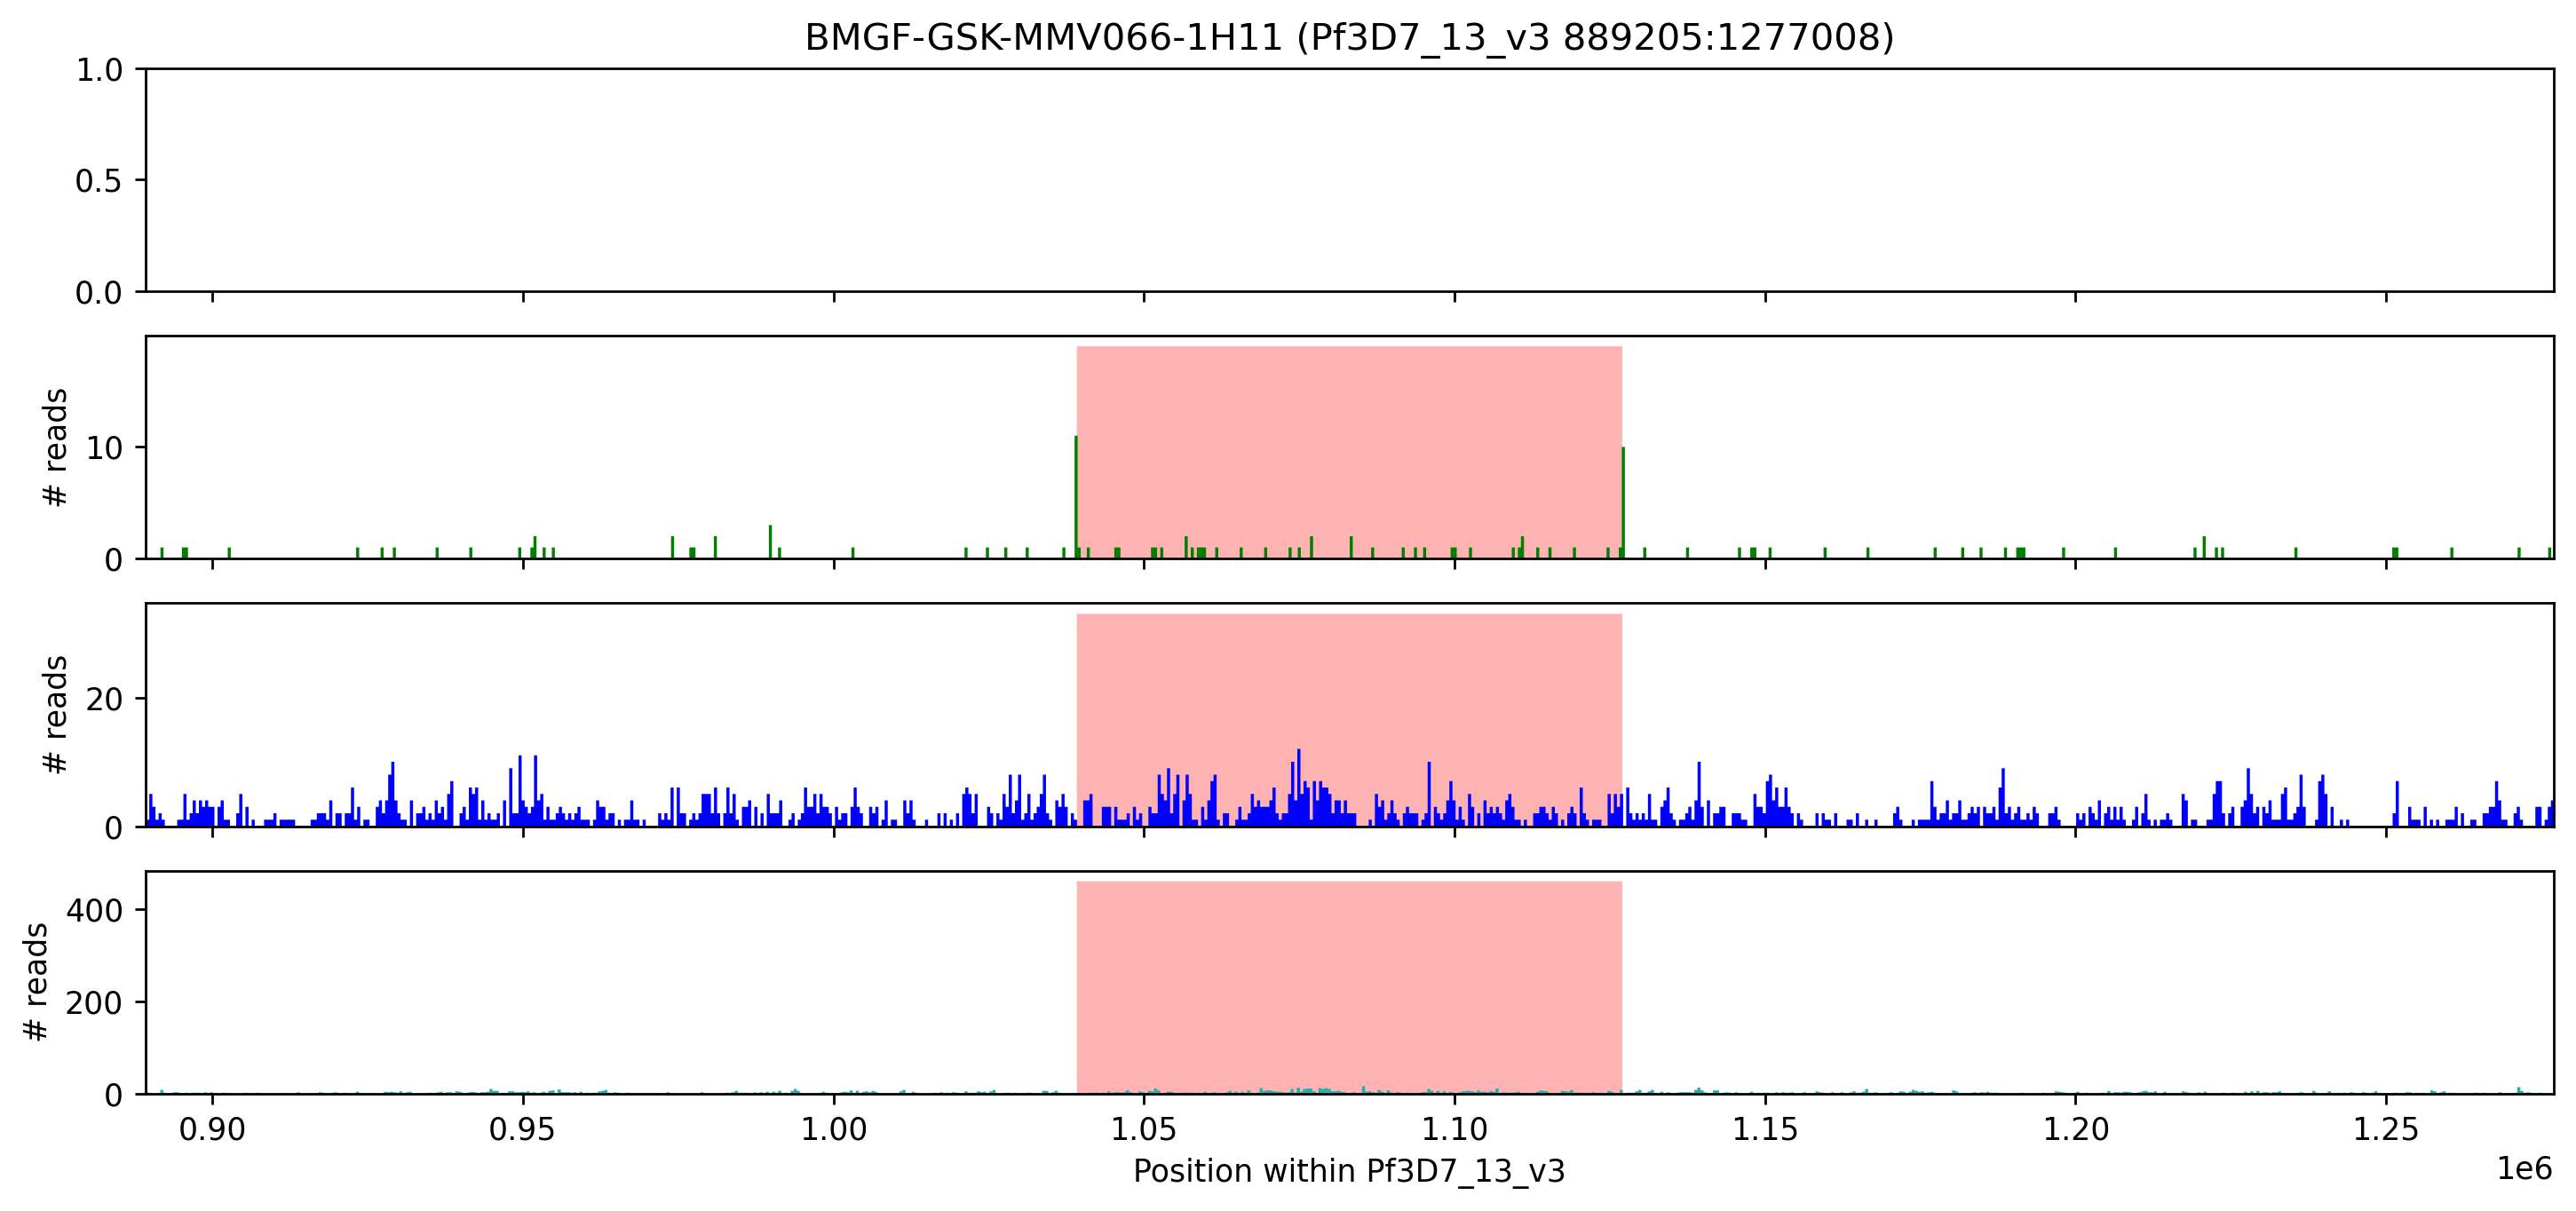

In [8]:
sample_name, chrom, predicted_start, predicted_end = \
'BMGF-GSK-MMV066-1H11	Pf3D7_13_v3	1039205	1127008'.split('\t')
sample_bam_name = clone_bam_name_dict[sample_name]
predicted_start = int(predicted_start); predicted_end = int(predicted_end)
strain = clone_strain_dict[sample_name]

# Get copy ratio info
chrom_interval_copyratio_dict = get_copyratio_dict(sample_bam_name, strain)

# Get predicted CNVs
predicted_CNVs = get_predicted_CNVs(sample_name)
print(predicted_CNVs)

# Get reads that may serve as evidence for duplication
RF_chrom_reads_dict, RR_chrom_reads_dict, FF_chrom_reads_dict = get_evidence_reads(sample_bam_name, strain)

# Choose a specific CNV
# chrom, predicted_start, predicted_end = ('Pf3D7_10_v3',1180755,1263319)

# Summarize copyratio info
cr_list = get_copyratio_list(chrom_interval_copyratio_dict, chrom, predicted_start, predicted_end)
print(np.mean(cr_list))

# Summarize support
read_type_start_support_dict, read_type_end_support_dict = summarize_support_around_CNV(chrom, predicted_start, predicted_end)

# Make plot
print(chrom, predicted_start, predicted_end)
plot_support_around_CNV(chrom, predicted_start, predicted_end, predicted_start - 150000, predicted_end + 150000,
                       other_chrom_only=False)

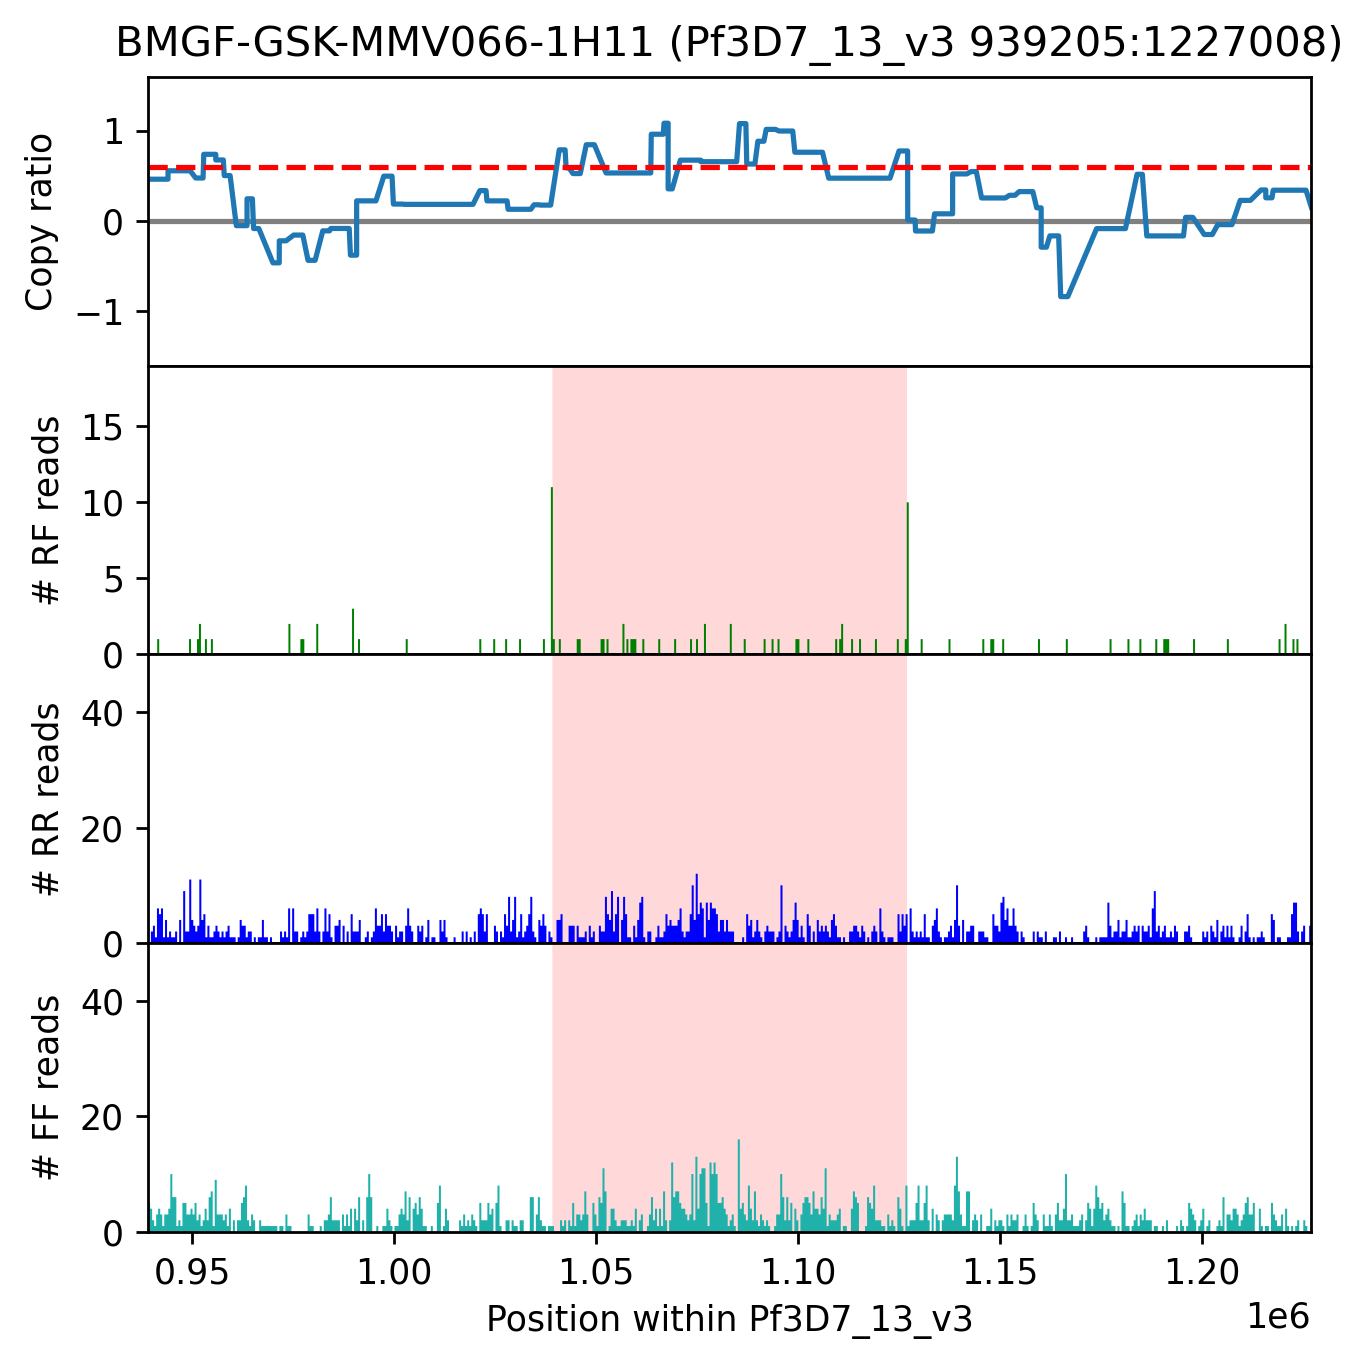

In [9]:
# 'BMGF-GSK-MMV066-1H11	Pf3D7_13_v3	1040907	1106086'.split('\t')
chrom_to_plot = chrom
x_min = predicted_start-100000
x_max = predicted_end+100000
other_chrom_only = False
nbins = chrom_length_dict[chrom_to_plot]//500

RF_xs = []; RR_xs = []; FF_xs = []

for flag, pos, seq_len, chrom_next, pos_next in RF_chrom_reads_dict[chrom_to_plot]:
    if chrom_next == '=' and np.abs(pos_next - pos) > 1000:
        RF_xs.append(pos)
for flag, pos, seq_len, chrom_next, pos_next in RR_chrom_reads_dict[chrom_to_plot]:
    if (not other_chrom_only) or (chrom_next != '='):
        RR_xs.append(pos)
for flag, pos, seq_len, chrom_next, pos_next in FF_chrom_reads_dict[chrom_to_plot]:
    if (not other_chrom_only) or (chrom_next != '='):
        FF_xs.append(pos)

fig, ax = plt.subplots(4, 1, figsize=(6, 6), sharex=True)

RF_counts, RF_bins = np.histogram(RF_xs, bins=nbins); ax[1].stairs(RF_counts, RF_bins, fill=True, color='green')
RR_counts, RR_bins = np.histogram(RR_xs, bins=nbins); ax[2].stairs(RR_counts, RR_bins, fill=True, color='blue')
FF_counts, FF_bins = np.histogram(FF_xs, bins=nbins); ax[3].stairs(FF_counts, FF_bins, fill=True, color='lightseagreen')

y_maxes = [max(RF_counts)+1, max(RR_counts)+1, max(FF_counts)+1]

for i in [1, 2, 3]:
    ax[i].fill_between(range(predicted_start, predicted_end), 0, 251, color='red', alpha=0.15, edgecolor=None, zorder=-5)
    if i == 1:
        ax[i].set_ylim((0, 19))
    else:
        ax[i].set_ylim((0, 50))
    for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom_to_plot]:
        ax[i].fill_between(range(noncore_start, noncore_end+1), 0, y_maxes[i-1], color='gray', alpha=0.3, edgecolor=None, zorder=-5)

ax[0].set_xlim((x_min, x_max))
ax[1].set_ylabel("# RF reads"); ax[2].set_ylabel("# RR reads"); ax[3].set_ylabel("# FF reads")
ax[0].set_title("%s (%s %i:%i)" % (sample_name, chrom_to_plot, x_min, x_max))
ax[3].set_xlabel("Position within %s" % chrom_to_plot)

CR_xs = []; CR_ys = []
for start, end in chrom_interval_copyratio_dict[chrom_to_plot]:
    y = chrom_interval_copyratio_dict[chrom_to_plot][(start, end)]
    CR_xs += [start, end]; CR_ys += [y, y]

ax[0].plot(CR_xs, CR_ys)
ax[0].axhline(y=0.6, linestyle='dashed', color='red')
ax[0].axhline(y=0, linestyle='solid', color='gray', zorder=-5)
ax[0].set_ylim((-1.6, 1.6))
ax[0].set_ylabel("Copy ratio")

fig.subplots_adjust(hspace=0)

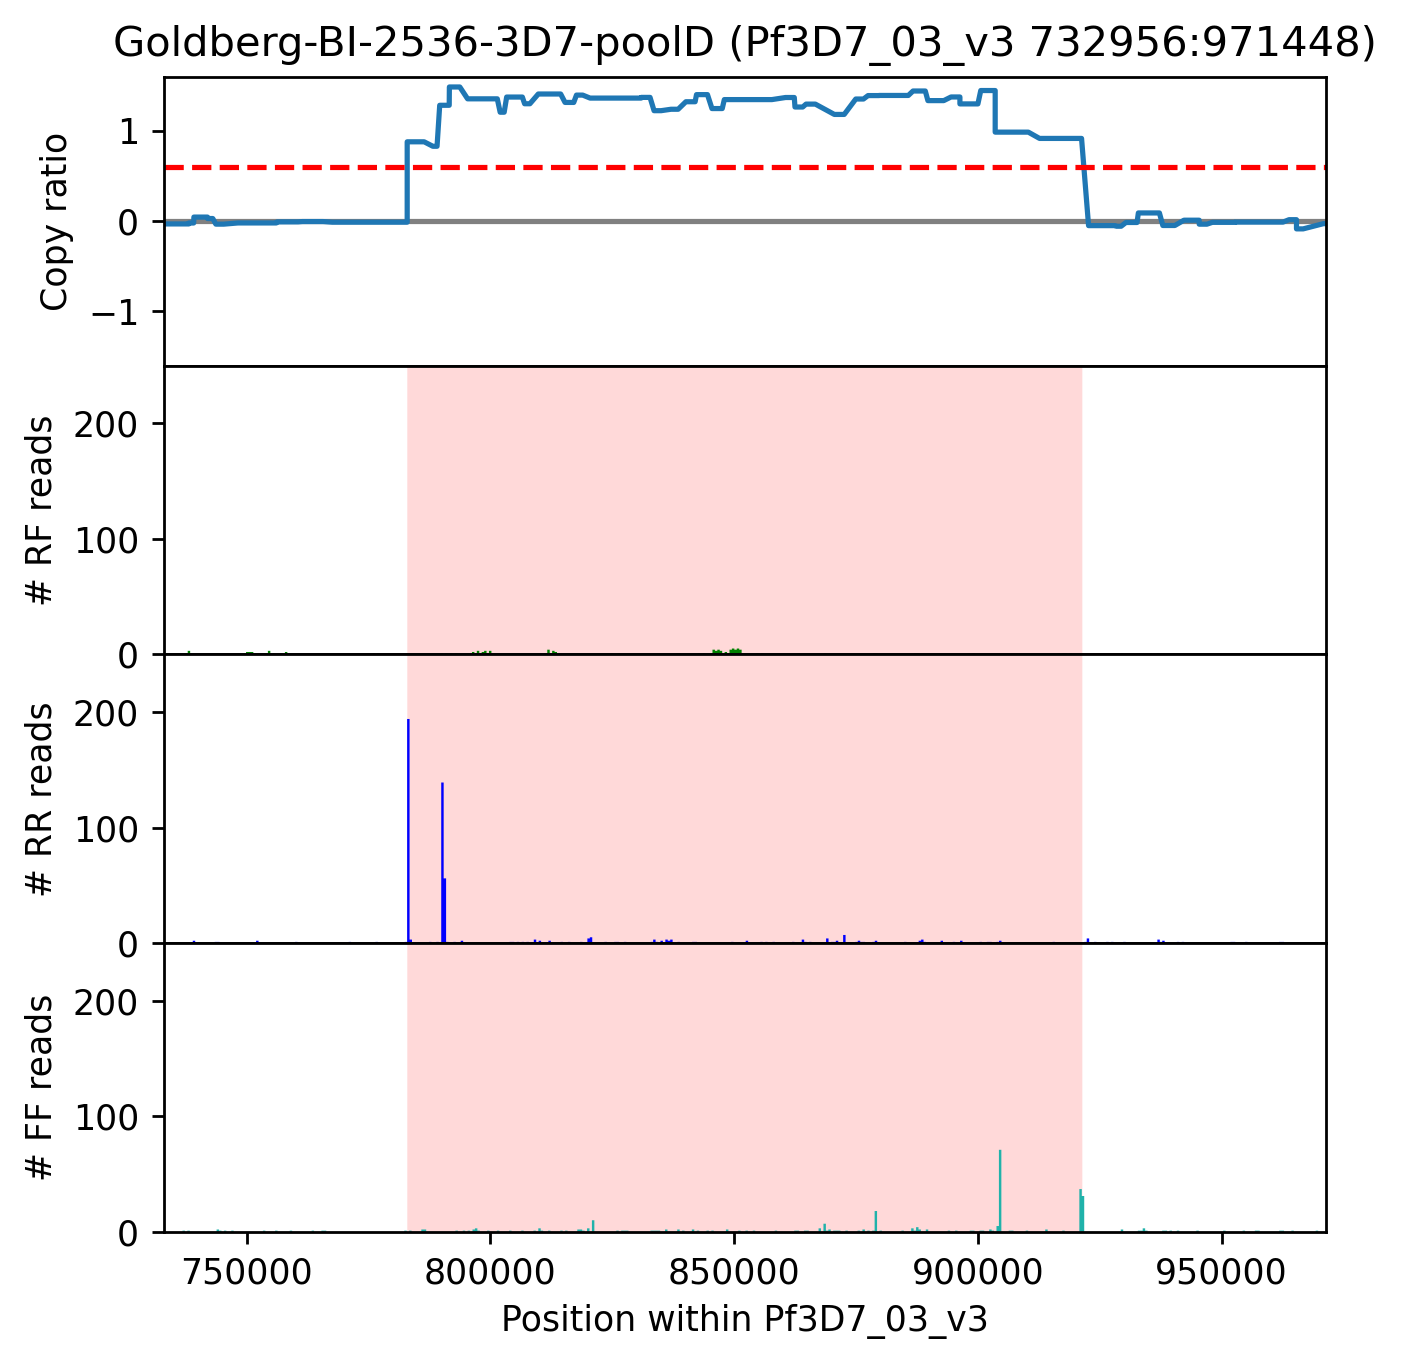

In [22]:
chrom_to_plot = chrom
x_min = predicted_start-50000
x_max = predicted_end+50000
other_chrom_only = False
nbins = chrom_length_dict[chrom_to_plot]//500

RF_xs = []; RR_xs = []; FF_xs = []

for flag, pos, seq_len, chrom_next, pos_next in RF_chrom_reads_dict[chrom_to_plot]:
    if chrom_next == '=' and np.abs(pos_next - pos) > 1000:
        RF_xs.append(pos)
for flag, pos, seq_len, chrom_next, pos_next in RR_chrom_reads_dict[chrom_to_plot]:
    if (not other_chrom_only) or (chrom_next != '='):
        RR_xs.append(pos)
for flag, pos, seq_len, chrom_next, pos_next in FF_chrom_reads_dict[chrom_to_plot]:
    if (not other_chrom_only) or (chrom_next != '='):
        FF_xs.append(pos)

fig, ax = plt.subplots(4, 1, figsize=(6, 6), sharex=True)

RF_counts, RF_bins = np.histogram(RF_xs, bins=nbins); ax[1].stairs(RF_counts, RF_bins, fill=True, color='green')
RR_counts, RR_bins = np.histogram(RR_xs, bins=nbins); ax[2].stairs(RR_counts, RR_bins, fill=True, color='blue')
FF_counts, FF_bins = np.histogram(FF_xs, bins=nbins); ax[3].stairs(FF_counts, FF_bins, fill=True, color='lightseagreen')

y_maxes = [max(RF_counts)+1, max(RR_counts)+1, max(FF_counts)+1]

for i in [1, 2, 3]:
    ax[i].fill_between(range(predicted_start, predicted_end), 0, 251, color='red', alpha=0.15, edgecolor=None, zorder=-5)
    ax[i].set_ylim((0, 250))
    for noncore_start, noncore_end in chrom_noncore_regions_dict[chrom_to_plot]:
        ax[i].fill_between(range(noncore_start, noncore_end+1), 0, y_maxes[i-1], color='gray', alpha=0.3, edgecolor=None, zorder=-5)

ax[0].set_xlim((x_min, x_max))
ax[1].set_ylabel("# RF reads"); ax[2].set_ylabel("# RR reads"); ax[3].set_ylabel("# FF reads")
ax[0].set_title("%s (%s %i:%i)" % (sample_name, chrom_to_plot, x_min, x_max))
ax[3].set_xlabel("Position within %s" % chrom_to_plot)

CR_xs = []; CR_ys = []
for start, end in chrom_interval_copyratio_dict[chrom_to_plot]:
    y = chrom_interval_copyratio_dict[chrom_to_plot][(start, end)]
    CR_xs += [start, end]; CR_ys += [y, y]

ax[0].plot(CR_xs, CR_ys)
ax[0].axhline(y=0.6, linestyle='dashed', color='red')
ax[0].axhline(y=0, linestyle='solid', color='gray', zorder=-5)
ax[0].set_ylim((-1.6, 1.6))
ax[0].set_ylabel("Copy ratio")

fig.subplots_adjust(hspace=0)

In [65]:
chrom_noncore_regions_dict

{'Pf3D7_01_v3': [(1, 92863), (575000, 640851)],
 'Pf3D7_02_v3': [(1, 112200), (860216, 947102)],
 'Pf3D7_03_v3': [(1, 69000), (1002000, 1067971)],
 'Pf3D7_04_v3': [(1, 100000),
  (545737, 615000),
  (934700, 987644),
  (1143742, 1200490)],
 'Pf3D7_05_v3': [(1, 43000), (1322150, 1343557)],
 'Pf3D7_06_v3': [(1, 72185), (722867, 742656), (1313458, 1418242)],
 'Pf3D7_07_v3': [(1, 77305), (511700, 603631), (1382160, 1445207)],
 'Pf3D7_08_v3': [(1, 72035), (430803, 466817), (1371597, 1472805)],
 'Pf3D7_09_v3': [(1, 79124), (1474181, 1541735)],
 'Pf3D7_10_v3': [(1, 69211), (1600156, 1687656)],
 'Pf3D7_11_v3': [(1, 77654), (2004504, 2038340)],
 'Pf3D7_12_v3': [(1, 57055),
  (766404, 785080),
  (1688356, 1743658),
  (2167931, 2271494)],
 'Pf3D7_13_v3': [(1, 72312), (2811456, 2925236)],
 'Pf3D7_14_v3': [(1, 32983), (3259777, 3291936)]}

In [13]:
# Wirth-Desoxyepothilone-B-Dd2-pol-delta-Parent-3-14-2020	Wirth-Desoxyepothilone-B-Dd2-pol-delta-Parent-3-5-2020
sample_bam_name = 'p_fal_Wirth-Desoxyepothilone-B-Dd2-pol-delta-Parent-3-5-2020_p'
clone = 'Wirth-Desoxyepothilone-B-Dd2-pol-delta-Parent-3-5-2020'
strain = 'Dd2'
parent_chrom_pos_cov_dict, parent_chrom_cov_dict = get_coverage_dict(sample_bam_name, strain)

In [10]:
def compute_running_average(xs, ys, interval):
    new_xs = []
    x_new_ys_dict = defaultdict(list)    
    for y, x in zip(ys, xs):
        new_x = (x // interval)*interval
        x_new_ys_dict[new_x].append(y)
        new_xs.append(new_x)
    new_ys = []
    for x in tqdm(range(0, max(xs), interval)):
        if x not in x_new_ys_dict:
            new_ys.append(0)
        else:
            new_ys.append(np.mean(x_new_ys_dict[x]))
    return (np.arange(0, max(xs), interval), new_ys)

def get_coverage_dict(sample_bam_name, strain):
    chrom_pos_cov_dict = defaultdict(dict)
    chrom_cov_dict = defaultdict(int)
    f = open('/storage/NFS/ANALYSIS/DNAseq/test/bam_coverage_%s/%s.genomecov.txt' % (strain, sample_bam_name), 'r')
    for line in f:
        chrom, pos, cov = line.strip().split('\t')
        pos = int(pos); cov = int(cov)
        chrom_pos_cov_dict[chrom][pos] = cov
        chrom_cov_dict[chrom] += cov
    return chrom_pos_cov_dict, chrom_cov_dict

def median_coverage_in_core_region(chrom, chrom_pos_cov_dict):
    cov_list = []
    prev_noncore_start, prev_noncore_end = chrom_noncore_regions_dict[chrom][0]
    for i in range(1, len(chrom_noncore_regions_dict[chrom])):
        noncore_start, noncore_end = chrom_noncore_regions_dict[chrom][i]
        for pos in range(prev_noncore_end+1, noncore_start):
            cov_list.append(chrom_pos_cov_dict[chrom][pos])
        prev_noncore_start, prev_noncore_end = noncore_start, noncore_end
    return np.median(cov_list)

[('Pf3D7_05_v3', 948701, 1054163), ('Pf3D7_10_v3', 1180755, 1263319)]


146062it [00:00, 148642.07it/s]


0.778133
Pf3D7_12_v3 974258 975855


100%|█████████████████████████████████| 227150/227150 [00:02<00:00, 111199.81it/s]


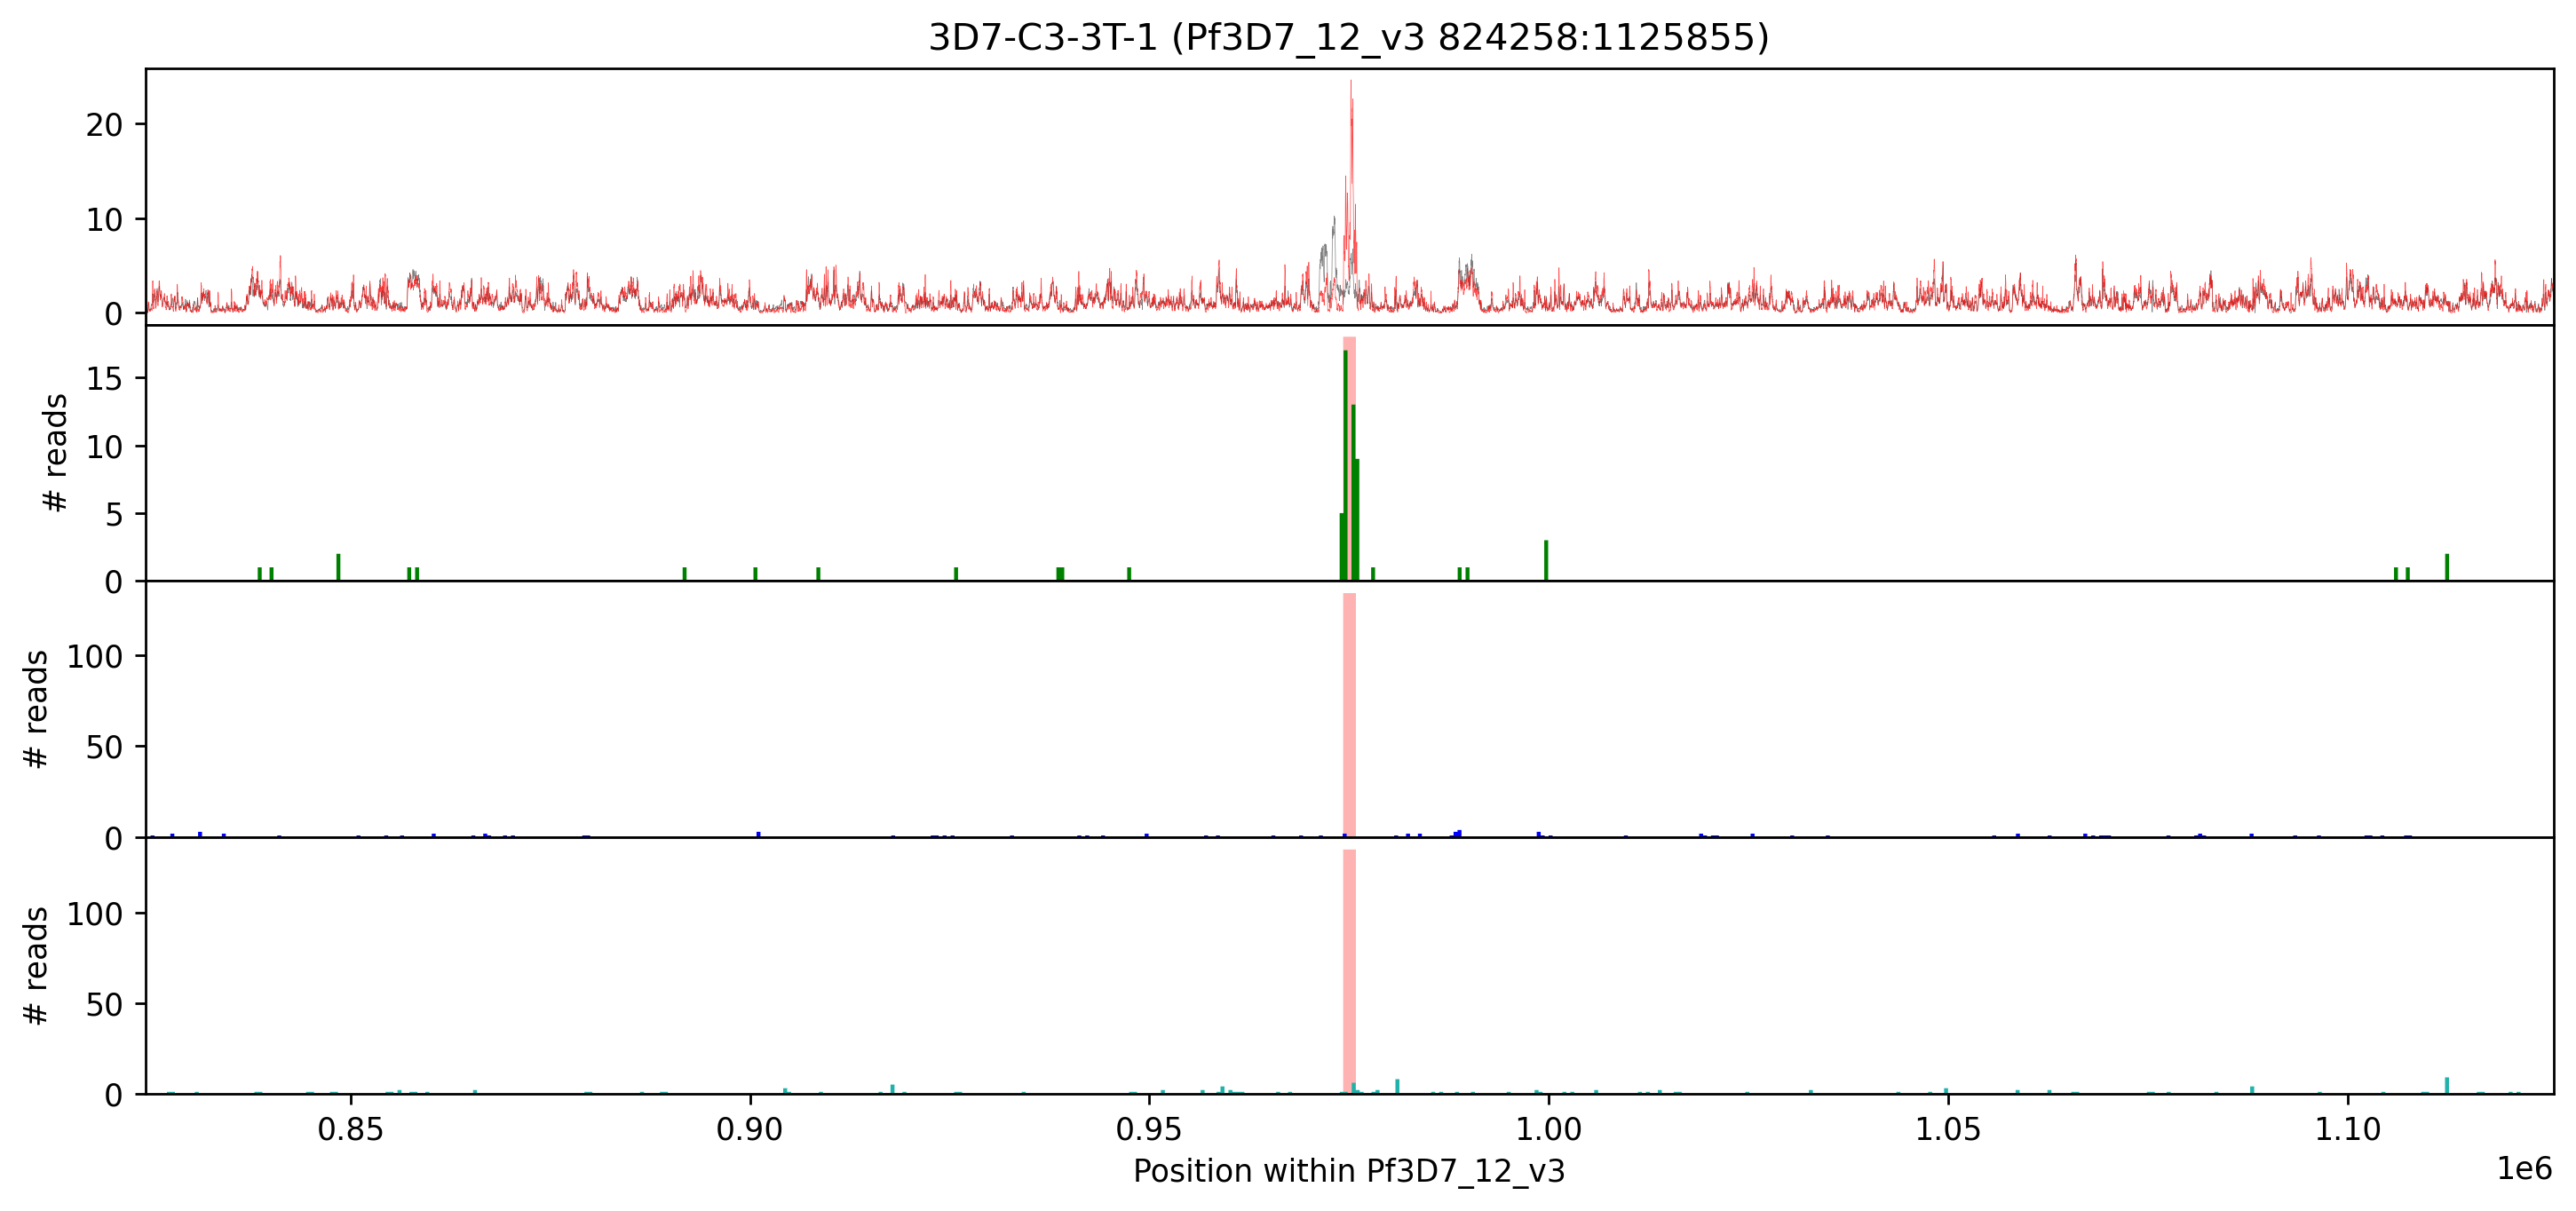

In [25]:
sample_name = '3D7-C3-3T-1'
strain = clone_strain_dict[sample_name]
sample_full_name = 'p_fal_%s_p' % sample_name

# Get coverage/copy ratio info
# chrom_interval_copyratio_dict = get_copyratio_dict(sample_full_name, strain)
sample_bam_name = 'p_fal_%s_p' % sample_name
chrom_pos_cov_dict, chrom_cov_dict = get_coverage_dict(sample_bam_name, strain)

# Get predicted CNVs
predicted_CNVs = get_predicted_CNVs(sample_name)
print(predicted_CNVs)

# Get reads that may serve as evidence for duplication
RF_chrom_reads_dict, RR_chrom_reads_dict, FF_chrom_reads_dict = get_evidence_reads(sample_full_name, strain)

# Choose a specific CNV
chrom, predicted_start, predicted_end = 'Pf3D7_12_v3	974258	975855'.split('\t')
predicted_start = int(predicted_start); predicted_end = int(predicted_end)

# Summarize copyratio info
# cr_list = get_copyratio_list(chrom_interval_copyratio_dict, chrom, predicted_start, predicted_end)
print(np.mean(cr_list))

# Summarize support
read_type_start_support_dict, read_type_end_support_dict = summarize_support_around_CNV(chrom, predicted_start, predicted_end)

# Make plot
print(chrom, predicted_start, predicted_end)
plot_support_around_CNV(chrom, predicted_start, predicted_end, predicted_start - 150000, predicted_end + 150000,
                       other_chrom_only=False, cov_not_CR=True)

Pf3D7_12_v3 1550074 1566829


100%|█████████████████████████████████| 227150/227150 [00:02<00:00, 109131.37it/s]


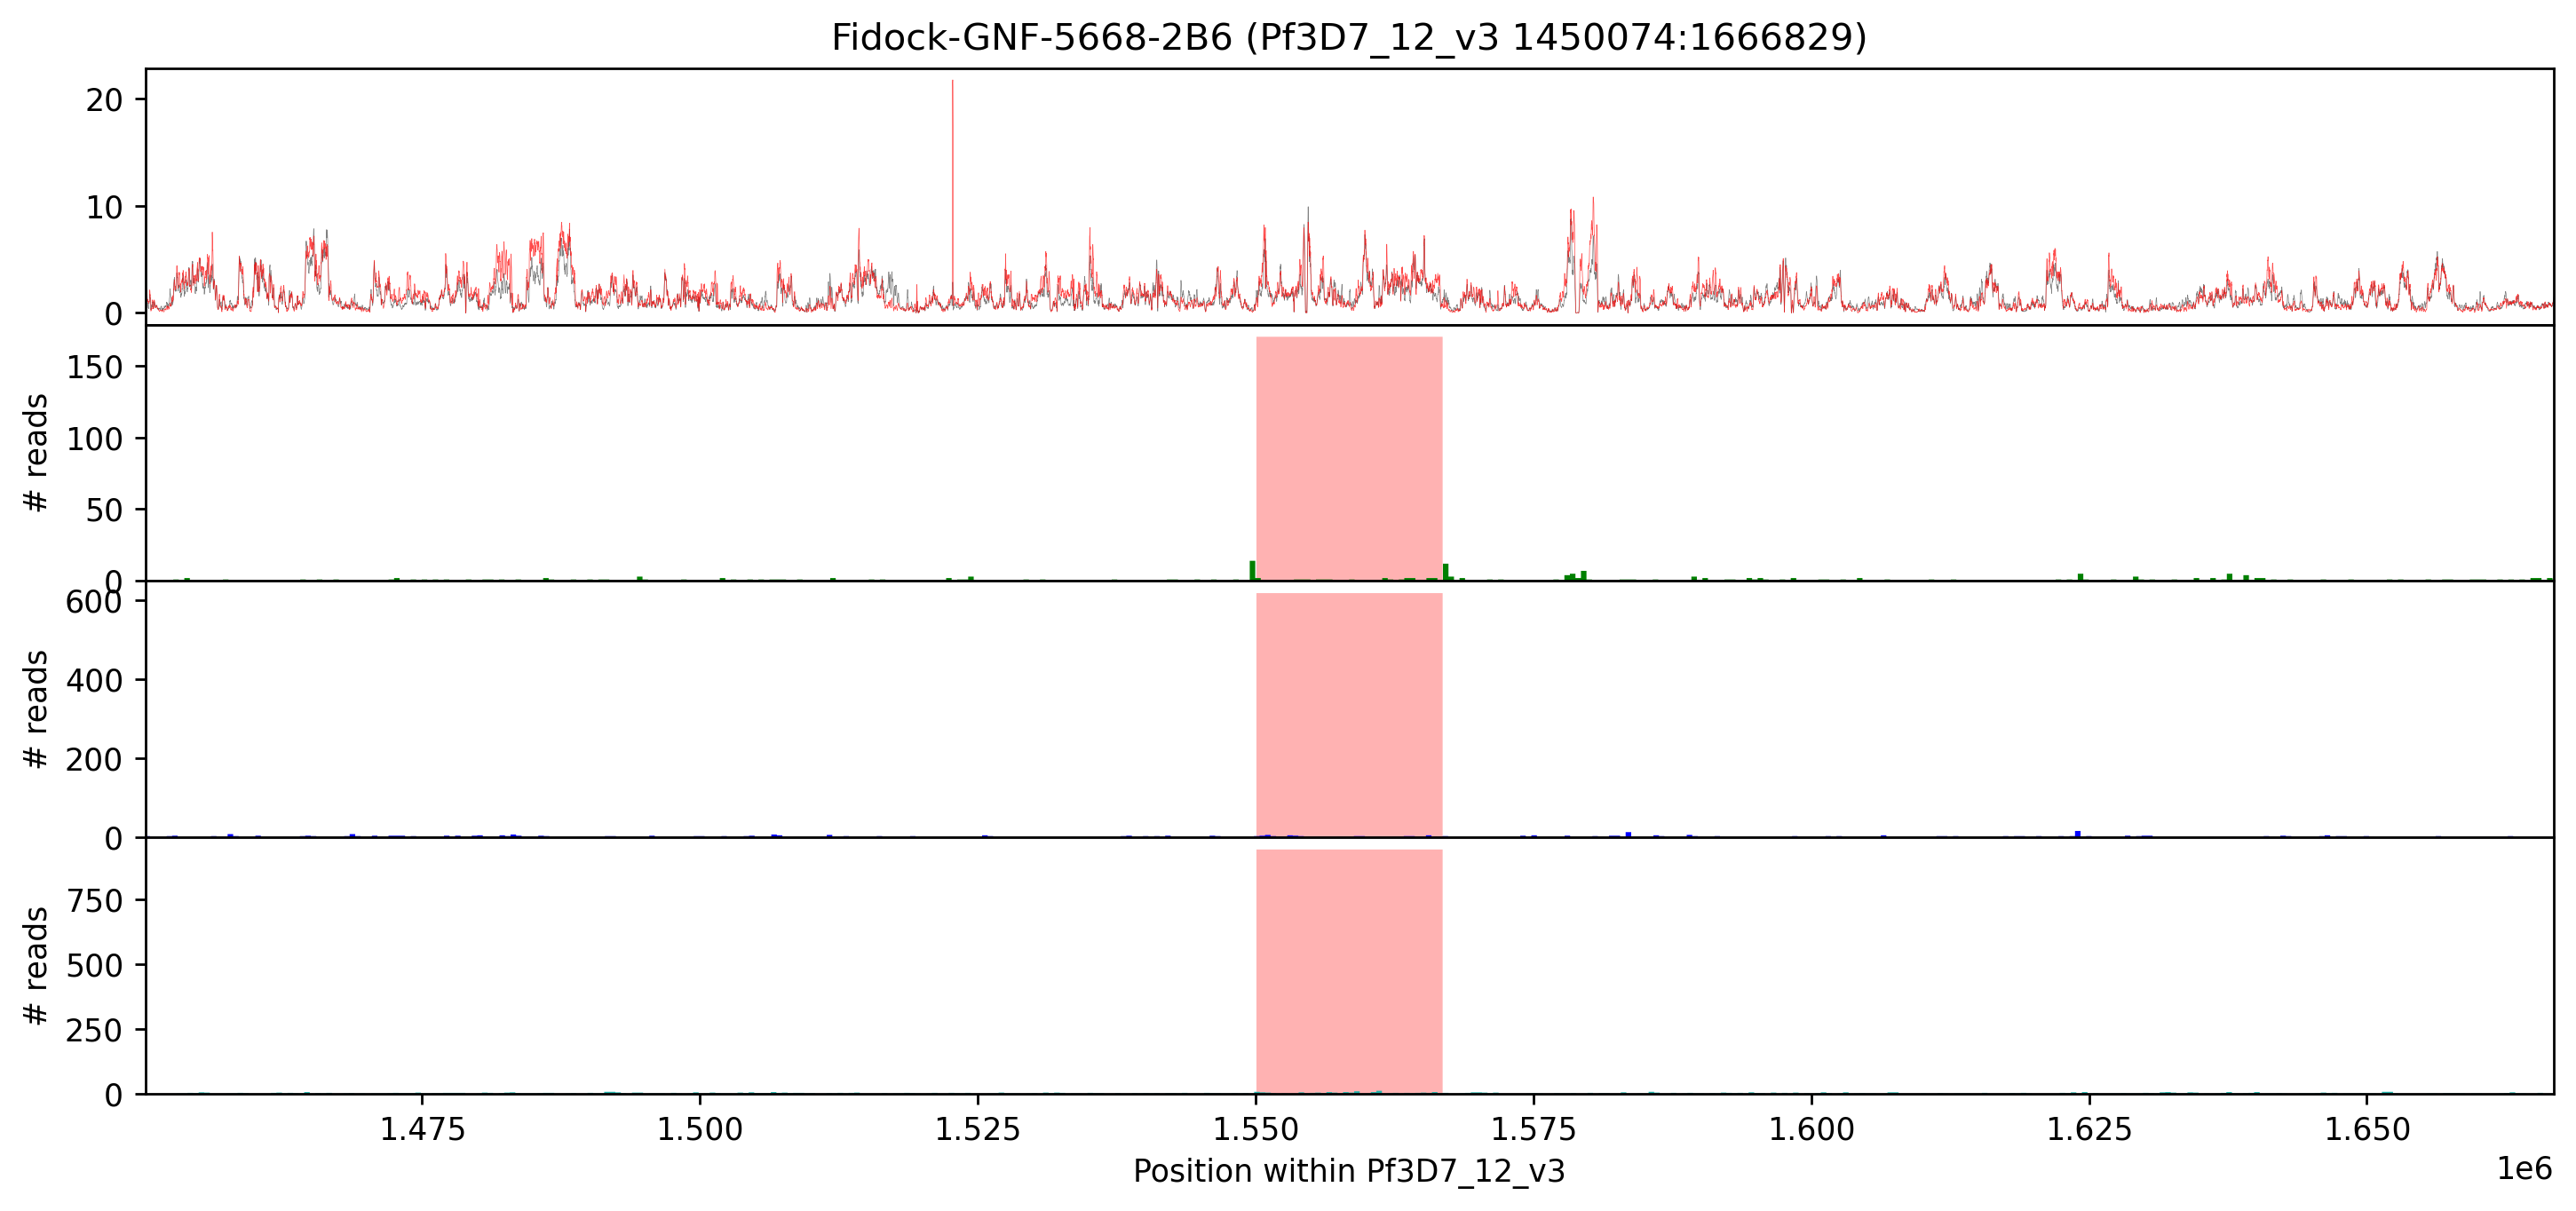

In [68]:
# Choose a specific CNV
chrom, predicted_start, predicted_end = 'Pf3D7_12_v3	1550074	1566829'.split('\t')
predicted_start = int(predicted_start); predicted_end = int(predicted_end)
# Summarize support
read_type_start_support_dict, read_type_end_support_dict = summarize_support_around_CNV(chrom, predicted_start, predicted_end)
# Make plot
print(chrom, predicted_start, predicted_end)
plot_support_around_CNV(chrom, predicted_start, predicted_end, predicted_start - 100000, predicted_end + 100000,
                       other_chrom_only=False, cov_not_CR=True)

In [57]:
import statistics
statistics.mode([tup[0] for tup in read_type_start_support_dict['RF']])

2000326

In [14]:
sample_bam_name = 'p_fal_cladorA_p'
clone = 'cladorA'
strain = 'Dd2'
chrom_pos_cov_dict, chrom_cov_dict = get_coverage_dict(sample_bam_name, strain)

100%|█████████████████████████████████| 134356/134356 [00:01<00:00, 110439.80it/s]


(830439.0, 1000393.0)

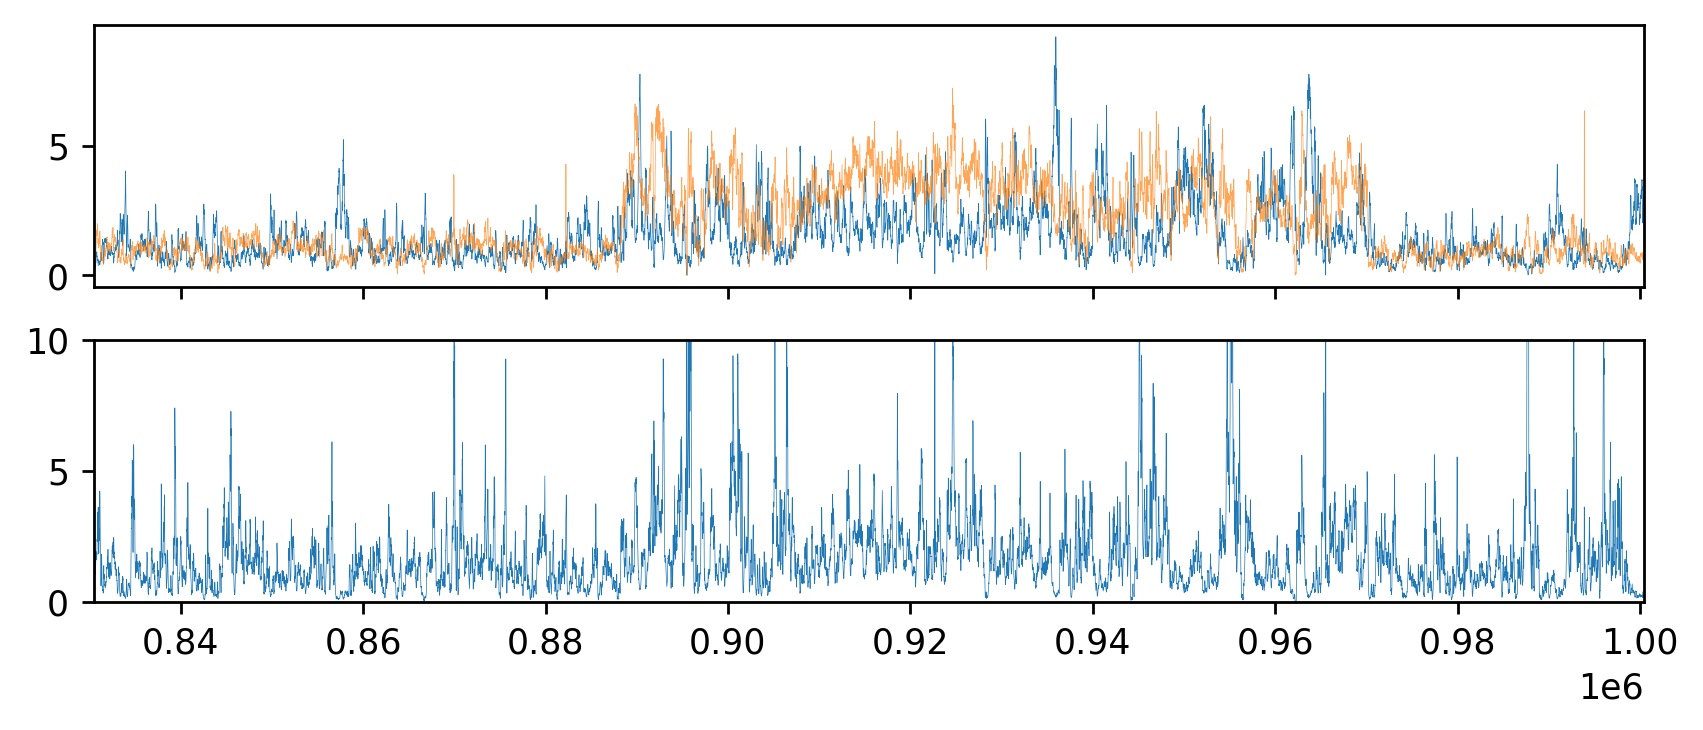

In [19]:
# Visualize fractional coverage
chrom = 'Pf3D7_05_v3'

fig, ax = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

x_min = 830439
x_max = 1000393

parent_cov_list = [parent_chrom_pos_cov_dict[chrom][pos] for pos in sorted(parent_chrom_pos_cov_dict[chrom])]
parent_frac_cov_list = np.array(parent_cov_list) / median_coverage_in_core_region(chrom, parent_chrom_pos_cov_dict)
xs, parent_ys = compute_running_average(np.arange(len(parent_frac_cov_list)), parent_frac_cov_list, interval=10)
xs_subset = []; parent_ys_subset = []
for x, parent_y in zip(xs, parent_ys):
    if x > x_min and x < x_max:
        xs_subset.append(x); parent_ys_subset.append(parent_y)
ax[0].plot(xs_subset, parent_ys_subset, linewidth=0.2)

cov_list = [chrom_pos_cov_dict[chrom][pos] for pos in sorted(chrom_pos_cov_dict[chrom])]
frac_cov_list = np.array(cov_list) / median_coverage_in_core_region(chrom, chrom_pos_cov_dict)
xs, ys = compute_running_average(np.arange(len(frac_cov_list)), frac_cov_list, interval=10)
xs_subset = []; ys_subset = []
for x, y in zip(xs, ys):
    if x > x_min and x < x_max:
        xs_subset.append(x); ys_subset.append(y)
ax[0].plot(xs_subset, ys_subset, linewidth=0.2, alpha=0.7)

parentnorm_frac_cov_list = []; parentnorm_xs = []
for x, parent_frac_cov, frac_cov in zip(xs, parent_ys, ys):
    if parent_frac_cov > 0:
        parentnorm_xs.append(x)
        parentnorm_frac_cov_list.append(frac_cov/float(parent_frac_cov))

ax[1].plot(parentnorm_xs, parentnorm_frac_cov_list, linewidth=0.2)
ax[1].set_ylim((0, 10))
ax[0].set_xlim((x_min, x_max))

In [50]:
import numpy as np
from collections import defaultdict
import sys

strain = '3D7'

FILTERED_BAM_DIR = '/storage/NFS/ANALYSIS/DNAseq/test/bam_sam_filtered_daisy_%s' % strain
OUTPUT_DIR = '/storage/NFS/ANALYSIS/DNAseq/test/daisy_test' # '/projects/winzeler/ANALYSIS/DNAseq/test/daisy_test'

WINDOW = 10000

# ================================================================
# Load core vs. non-core regions
# ================================================================

bangladesh_dir = '/storage/NFS/ROTATION_PROJECT/daisy/bangladesh'
f = open('%s/bangladesh_samples.txt' % bangladesh_dir, 'r')
bangladesh_samples = [line.strip() for line in f]
vcf_file = open('%s/data/%s.ann.txt' % (bangladesh_dir, bangladesh_samples[0]), 'rt')

chrom_length_dict = {}

for line in vcf_file:
    if line[:8] == '##contig':
        chrom = line.split('ID=')[1].split(',')[0]
        length = int(line.split('length=')[1].split('>')[0])
        chrom_length_dict[chrom] = length
    if line[:2] != '##':
        break

chromosomes = list(chrom_length_dict.keys())

genome_ref_dir = '/storage/NFS/ROTATION_PROJECT/daisy/REF_DATA/pfal/'
f = open("%s/3D7_chromosome_noncore_regions.txt" % (genome_ref_dir), 'r')

chrom_noncore_regions_dict = defaultdict(list)

for line in f:
	items = line.strip().split(' ')
	chrom, start, end = items
	if chrom not in ['M76611', 'PFC10_API_IRAB']:
		if start == 'start':
			start = 1
		elif end == 'end':
			end = chrom_length_dict[chrom]
		
		end = int(end); start = int(start)
		chrom_noncore_regions_dict[chrom].append((start, end))

NONCORE_BUFFER = 10000

def pos_near_noncore_region(chrom, pos):
	for start, end in chrom_noncore_regions_dict[chrom]:
		if pos > (start - NONCORE_BUFFER) and pos < (end + NONCORE_BUFFER):
			return (start, end)
	return False

def pos_near_subtelomere(chrom, pos, buffer = NONCORE_BUFFER):
	for start, end in chrom_noncore_regions_dict[chrom][:2]:
		if pos > (start - buffer) and pos < (end + buffer):
			return True
	return False

# ================================================================
# Get predicted CNVs
# ================================================================

def get_predicted_CNVs(sample_name):
	predicted_CNVs = []
	
	f = open('%s/CNVprobabilityvalues.tsv' % OUTPUT_DIR, 'r')
	header = f.readline()
	
	for line in f:
		items = line.rstrip().split('\t')
		if items[0] == "":
			break
		clone_name, compound, pval, CNV_start, CNV_end, CNV_dir, chrom = items[:7]
		pval = float(pval)
		if clone_name == sample_name:
			predicted_CNVs.append((chrom, int(CNV_start), int(CNV_end)))
	
	return predicted_CNVs

def get_CNV_pval_dict():
	CNV_pval_dict = {}	
	f = open('%s/CNVprobabilityvalues.tsv' % OUTPUT_DIR, 'r')
	header = f.readline()	
	for line in f:
		items = line.rstrip().split('\t')
		if items[0] == "":
			break
		clone_name, compound, pval, CNV_start, CNV_end, CNV_dir, chrom = items[:7]
		CNV_pval_dict[(clone_name, chrom, int(CNV_start), int(CNV_end))] = float(pval)
	
	return CNV_pval_dict

# ================================================================
# Get reads that may serve as evidence for tandem duplication
# ================================================================

def get_supporting_reads_dict(sample_bam_name):
	chrom_reads_dict = {rtype: defaultdict(list) for rtype in ['RR', 'RF', 'FF']}
	
	try:
		f = open('%s/%s_INVDUP.sam' % (FILTERED_BAM_DIR, sample_bam_name), 'r')
	except:
		return False
	
	for line in f:
		items = line.strip().split('\t')
		qname, flag, chrom, pos, mapq, cigar, chrom_next, pos_next, tlen, seq, qual = items[:11]
		flag = int(flag); pos = int(pos); mapq = int(mapq); pos_next = int(pos_next); insert_size = np.abs(int(tlen))
		
		if mapq >= 20:
			if flag in [97, 81, 145, 161] and insert_size > 1000:
				chrom_reads_dict['RF'][chrom].append((flag, pos, len(seq), chrom_next, pos_next))
			elif flag in [177, 113]:
				chrom_reads_dict['RR'][chrom].append((flag, pos, len(seq), chrom_next, pos_next))
			elif flag in [65, 129]:
				chrom_reads_dict['FF'][chrom].append((flag, pos, len(seq), chrom_next, pos_next))
	
	return chrom_reads_dict

# ==================================================================
# Sliding window to find most likely location of start and end pos
# ==================================================================

def infer_tandem_boundaries(start_pos_count_dict, end_pos_count_dict):
	window = 100
	window_start_count_dict = defaultdict(int) # Start of window -> count of read start positions in that window
	
	for ipos in start_pos_count_dict:
		for pos in np.arange(ipos, ipos + window):
			if pos in start_pos_count_dict:
				window_start_count_dict[ipos] += start_pos_count_dict[pos]
	
	best_window_start = max(start_pos_count_dict.keys())
	max_count = window_start_count_dict[best_window_start]
	
	for window_start in sorted(window_start_count_dict.keys(), reverse=True):
		if window_start_count_dict[window_start] > max_count:
			best_window_start = window_start
			max_count = window_start_count_dict[window_start]
	
	start_support = max_count
	mode_pos = best_window_start
	mode = start_pos_count_dict[mode_pos] # Mode within the window
	
	for pos in np.arange(best_window_start, best_window_start + window):
		if start_pos_count_dict[pos] > mode:
			mode_pos = pos
			mode = start_pos_count_dict[pos]
	
	# Starting from mode of window, move left until read count is <=1 within window of 20 on the left side	
	predicted_start_pos = mode_pos # Predicted start of CNV
	cur_read_count = sum([start_pos_count_dict[pos] for pos in range(predicted_start_pos-20, predicted_start_pos)])	
	while cur_read_count > 1:
		predicted_start_pos -= 1
		cur_read_count = sum([start_pos_count_dict[pos] for pos in range(predicted_start_pos-20, predicted_start_pos)])
	
	window = 100
	window_start_count_dict = defaultdict(int) # Start of window -> count of read end positions in that window
	
	for ipos in end_pos_count_dict:
		for pos in np.arange(ipos, ipos + window):
			if pos in end_pos_count_dict:
				window_start_count_dict[ipos] += end_pos_count_dict[pos]
	
	best_window_start = min(end_pos_count_dict.keys())
	max_count = window_start_count_dict[best_window_start]
	
	for window_start in window_start_count_dict:
		if window_start_count_dict[window_start] > max_count:
			best_window_start = window_start
			max_count = window_start_count_dict[window_start]
	
	end_support = max_count
	mode_pos = best_window_start
	mode = end_pos_count_dict[mode_pos] # Mode within the window
	
	for pos in np.arange(best_window_start, best_window_start + window):
		if end_pos_count_dict[pos] > mode:
			mode_pos = pos
			mode = end_pos_count_dict[pos]
	
	# Starting from mode of window, move right until read count is <=1 within window of 20 on the right side
	predicted_end_pos = mode_pos
	cur_read_count = sum([end_pos_count_dict[pos] for pos in range(predicted_end_pos+1, predicted_end_pos+21)])	
	while cur_read_count > 1:
		predicted_end_pos += 1
		cur_read_count = sum([end_pos_count_dict[pos] for pos in range(predicted_end_pos+1, predicted_end_pos+21)])
	
	return (predicted_start_pos, predicted_end_pos, start_support, end_support)

# ==================================================================
# Verify consistent mapping of mates
# ==================================================================

def check_consistent_mates(pos_pair_dict, filter_func=lambda x: True, threshold=5, window=50, single_chrom=False):
		
	chrom_pos_count_dict = {chrom: defaultdict(int) for chrom in chromosomes}
	subtelomere_count = 0
	for pos in pos_pair_dict:
		if filter_func(pos):
			for key in pos_pair_dict[pos]:
				if single_chrom:
					mate_pos = key; mate_chrom = single_chrom
				else:
					mate_chrom, mate_pos = key
				if pos_near_subtelomere(mate_chrom, mate_pos, buffer = 100):
					subtelomere_count += 1
				else:
					chrom_pos_count_dict[mate_chrom][mate_pos] += 1
	#print(chrom_pos_count_dict)
	if subtelomere_count >= threshold:
		return ("Subtelomere", -1, subtelomere_count)
	
	for chrom in chrom_pos_count_dict:
		window_start_count_dict = defaultdict(int) # Start of window -> count of read positions in that window
		for ipos in chrom_pos_count_dict[chrom].keys():
			for pos in np.arange(ipos, ipos + window):
				if pos in chrom_pos_count_dict[chrom]:
					window_start_count_dict[ipos] += chrom_pos_count_dict[chrom][pos]
		if len(window_start_count_dict) == 0:
			continue
		max_count_pos, max_count = sorted(window_start_count_dict.items(), key=lambda x: x[1])[-1]
		print(chrom, max_count_pos, max_count)
		if max(window_start_count_dict.values()) >= threshold:
			return (chrom, max_count_pos, max_count)
	
	return False
		
	chrom_pos_count_dict = {chrom: defaultdict(int) for chrom in chromosomes}
	subtelomere_count = 0
	for pos in pos_pair_dict:
		
		for key in pos_pair_dict[pos]:
			if single_chrom:
				mate_pos = key; mate_chrom = single_chrom
			else:
				mate_chrom, mate_pos = key
			if pos_near_subtelomere(mate_chrom, mate_pos, buffer = 100):
				subtelomere_count += 1
			else:
				chrom_pos_count_dict[mate_chrom][mate_pos] += 1
	
	if subtelomere_count >= threshold:
		return ("Subtelomere", -1, subtelomere_count)
	
	for chrom in chrom_pos_count_dict:
		window_start_count_dict = defaultdict(int) # Start of window -> count of read positions in that window
		for ipos in chrom_pos_count_dict[chrom].keys():
			for pos in np.arange(ipos, ipos + window):
				if pos in chrom_pos_count_dict[chrom]:
					window_start_count_dict[ipos] += chrom_pos_count_dict[chrom][pos]
		if len(window_start_count_dict) == 0:
			continue
		max_count_pos, max_count = sorted(window_start_count_dict.items(), key=lambda x: x[1])[-1]
		if max(window_start_count_dict.values()) >= threshold:
			return (chrom, max_count_pos, max_count)
	
	return False

# ==================================================================
# Sliding window to find potential enrichment peak
# ==================================================================

def quantify_enrichment(chrom_pos_count_dict, filter_func, window=50):
	window_start_count_dict = defaultdict(int) # Start of window -> count of read positions in that window

	for ipos in chrom_pos_count_dict.keys():
		if filter_func(ipos):
			for pos in np.arange(ipos, ipos + window):
				if pos in chrom_pos_count_dict:
					window_start_count_dict[ipos] += chrom_pos_count_dict[pos]

	best_window_start = min(chrom_pos_count_dict.keys())
	max_count = window_start_count_dict[best_window_start]

	for window_start in window_start_count_dict:
		if window_start_count_dict[window_start] > max_count:
			best_window_start = window_start
			max_count = window_start_count_dict[window_start]

	mode_pos = best_window_start
	mode = chrom_pos_count_dict[mode_pos] # Mode within the window
		
	for pos in np.arange(best_window_start, best_window_start + window):
		if chrom_pos_count_dict[pos] > mode:
			mode_pos = pos
			mode = chrom_pos_count_dict[pos]
	
	return (max_count, mode, mode_pos)

# ================================================================
# Filter pos_count_dict to positions within window with the highest total count
# ================================================================

def filter_pos_count_dict_to_window(pos_count_dict, window=300):
	
	if len(pos_count_dict) == 0:
		return pos_count_dict
	
	sorted_pos_list = sorted(pos_count_dict.keys())
	window_count_dict = defaultdict(int)
	
	for i in range(len(sorted_pos_list)):
		start_pos = sorted_pos_list[i]; j = i
		while j < len(sorted_pos_list) and sorted_pos_list[j] < start_pos + window:
			window_count_dict[start_pos] += pos_count_dict[sorted_pos_list[j]]; j += 1
	
	max_count_start_pos, max_count = sorted(window_count_dict.items(), key=lambda x: x[1])[-1]
	
	new_pos_count_dict = defaultdict(int)
	for pos in sorted_pos_list:
		if pos >= max_count_start_pos and pos < (max_count_start_pos + window):
			new_pos_count_dict[pos] = pos_count_dict[pos]
	
	return new_pos_count_dict

# ================================================================
# Validate a particular CNV
# ================================================================

def pos_within_window(pos, ref_pos, window):
	return pos >= (ref_pos - window) and pos <= (ref_pos + window)

# Start here

In [31]:
CNV_pval_dict = get_CNV_pval_dict()

sample_bam_name = "p_fal_BMGF-Wirth-4114-2H12_p"
sample_name = sample_bam_name.split('_p')[0]
if sample_name.startswith('p_fal_'):
    sample_name = sample_name.split('p_fal_')[1]

predicted_CNVs = get_predicted_CNVs(sample_name)

CNV_chrom_start_end_dict = defaultdict(dict); CNV_chrom_end_start_dict = defaultdict(dict)
for chrom, start, end in predicted_CNVs:
    CNV_chrom_start_end_dict[chrom][start] = end; CNV_chrom_end_start_dict[chrom][end] = start

for chrom in CNV_chrom_start_end_dict:
    for start1 in CNV_chrom_start_end_dict[chrom].keys():
        end1 = CNV_chrom_start_end_dict[chrom][start1]
        for end2 in CNV_chrom_end_start_dict[chrom].keys():
            start2 = CNV_chrom_end_start_dict[chrom][end2]
            if (start1 - end2) > 0 and (start1 - end2) < 40000:
                predicted_CNVs.append((chrom, start2, end1))

chrom_reads_dict = get_supporting_reads_dict(sample_bam_name)

cnv_info = predicted_CNVs[1]
print(cnv_info)

('Pf3D7_01_v3', 106947, 153027)


In [32]:
RF_start_pos_count_dict = defaultdict(int)
RF_end_pos_count_dict = defaultdict(int)

RR_pos_pair_dict = defaultdict(list) # Pos within window of either CNV start or end, mate pos
RR_pos_count_dict = defaultdict(int)
FF_pos_pair_dict = defaultdict(list) # Pos within window of either CNV start or end, mate pos
FF_pos_count_dict = defaultdict(int)

RR_otherchrom_pos_pair_dict = defaultdict(list) # Pos within window of either CNV start or end, (mate chrom, mate pos)
RR_otherchrom_pos_count_dict = defaultdict(int)
FF_otherchrom_pos_pair_dict = defaultdict(list) # Pos within window of either CNV start or end, (mate chrom, mate pos)
FF_otherchrom_pos_count_dict = defaultdict(int)

tandem_supporting_reads = 0
total_supporting_reads = 0

tandem_altered_CNV_boundary_flag = False

CNV_chrom, CNV_start, CNV_end = cnv_info

pos_in_start_candidate_region = lambda pos: pos_within_window(pos, CNV_start, WINDOW)
pos_in_end_candidate_region = lambda pos: pos_within_window(pos, CNV_end, WINDOW)

# Check if either start or end is close to a hypervariable region
start_noncore_region = pos_near_noncore_region(CNV_chrom, CNV_start)
end_noncore_region = pos_near_noncore_region(CNV_chrom, CNV_end)

if start_noncore_region is not False: # Start near noncore
    noncore_start, noncore_end = start_noncore_region
    pos_in_start_candidate_region = lambda pos: (pos >= noncore_start - 1000 and pos <= noncore_end + 1000) or pos_within_window(pos, CNV_start, WINDOW)

if end_noncore_region is not False: # End near noncore
    noncore_start, noncore_end = end_noncore_region
    pos_in_end_candidate_region = lambda pos: (pos >= noncore_start - 1000 and pos <= noncore_end + 1000) or pos_within_window(pos, CNV_end, WINDOW)

# Validate each CNV: start by searching for potentially supporting reads
for flag, pos, seq_len, mate_chrom, mate_pos in chrom_reads_dict['RF'][CNV_chrom]:

    if flag in [81, 145] and pos_in_start_candidate_region(pos):
        if mate_chrom == '=' and pos_in_end_candidate_region(mate_pos + seq_len):
            RF_start_pos_count_dict[pos] += 1
            RF_end_pos_count_dict[mate_pos + seq_len] += 1
            total_supporting_reads += 1; tandem_supporting_reads += 1

    elif flag in [97, 161] and pos_in_end_candidate_region(pos + seq_len):
        if mate_chrom == '=' and pos_in_start_candidate_region(mate_pos):
            RF_start_pos_count_dict[mate_pos] += 1
            RF_end_pos_count_dict[pos + seq_len] += 1
            total_supporting_reads += 1; tandem_supporting_reads += 1

if tandem_supporting_reads < 4: # Only if there are not enough initial candidates, consider incorrect CNV segmentation
    tandem_altered_CNV_boundary_flag = True
    for flag, pos, seq_len, mate_chrom, mate_pos in chrom_reads_dict['RF'][CNV_chrom]:		
        if flag in [81, 145] and pos_within_window(pos, CNV_start, WINDOW) and mate_chrom == '=' and (mate_pos - pos) > 1000:
                RF_start_pos_count_dict[pos] += 1
                RF_end_pos_count_dict[mate_pos + seq_len] += 1
                total_supporting_reads += 1
        elif flag in [97, 161] and pos_within_window(pos + seq_len, CNV_end, WINDOW) and mate_chrom == '=' and (pos - mate_pos) > 1000:
                RF_start_pos_count_dict[mate_pos] += 1
                RF_end_pos_count_dict[pos + seq_len] += 1
                total_supporting_reads += 1

    RF_start_pos_count_dict = filter_pos_count_dict_to_window(RF_start_pos_count_dict, window=300)
    tandem_supporting_reads += sum(RF_start_pos_count_dict.values())
    RF_end_pos_count_dict = filter_pos_count_dict_to_window(RF_end_pos_count_dict, window=300)
    tandem_supporting_reads += sum(RF_end_pos_count_dict.values())

for flag, pos, seq_len, mate_chrom, mate_pos in chrom_reads_dict['RR'][CNV_chrom]:
    if (pos_within_window(pos, CNV_start, WINDOW) or pos_within_window(pos, CNV_end, WINDOW)):
        if mate_chrom == '=':
            RR_pos_pair_dict[pos].append(mate_pos)
            RR_pos_count_dict[pos] += 1
        else:
            RR_otherchrom_pos_pair_dict[pos].append((mate_chrom, mate_pos))
            RR_otherchrom_pos_count_dict[pos] += 1
        total_supporting_reads += 1

    if mate_chrom == '=' and ((pos_within_window(mate_pos, CNV_start, WINDOW) or pos_within_window(mate_pos, CNV_end, WINDOW))):
        RR_pos_pair_dict[mate_pos].append(pos)
        RR_pos_count_dict[mate_pos] += 1
        total_supporting_reads += 1

for flag, pos, seq_len, mate_chrom, mate_pos in chrom_reads_dict['FF'][CNV_chrom]:
    if (pos_within_window(pos, CNV_start, WINDOW) or pos_within_window(pos, CNV_end, WINDOW)):
        if mate_chrom == '=':
            FF_pos_pair_dict[pos].append(mate_pos)
            FF_pos_count_dict[pos] += 1
        else:
            FF_otherchrom_pos_pair_dict[pos].append((mate_chrom, mate_pos))
            FF_otherchrom_pos_count_dict[pos] += 1
        total_supporting_reads += 1

    if mate_chrom == '=' and ((pos_within_window(mate_pos, CNV_start, WINDOW) or pos_within_window(mate_pos, CNV_end, WINDOW))):
        FF_pos_pair_dict[mate_pos].append(pos)
        FF_pos_count_dict[mate_pos] += 1
        total_supporting_reads += 1

In [38]:
CNV_end

153027

In [39]:
print(total_supporting_reads)
print(tandem_supporting_reads)
print(RF_start_pos_count_dict)
print(RF_end_pos_count_dict)
#print(RR_pos_pair_dict)
#print(FF_pos_pair_dict)
print(RR_otherchrom_pos_count_dict)
print(FF_otherchrom_pos_count_dict)

1450
2
defaultdict(<class 'int'>, {109772: 1})
defaultdict(<class 'int'>, {176958: 1})
defaultdict(<class 'int'>, {98737: 1, 98748: 1, 98915: 1, 99588: 1, 100343: 1, 100560: 1, 104125: 1, 106307: 1, 106768: 1, 106775: 1, 107211: 1, 108465: 1, 108540: 1, 108542: 1, 108658: 1, 108666: 1, 108944: 1, 109520: 1, 109843: 1, 109899: 1, 112080: 1, 112095: 1, 112351: 1, 114615: 1, 114959: 1, 114967: 1, 115293: 1, 115826: 1, 115927: 1, 116417: 1, 143368: 1, 144032: 1, 144337: 1, 144552: 1, 144804: 1, 145344: 1, 145499: 1, 145608: 1, 146299: 1, 146397: 1, 146584: 1, 146899: 2, 147131: 1, 147348: 1, 147813: 1, 148039: 1, 148113: 1, 148277: 1, 148298: 1, 148433: 1, 150435: 1, 150964: 1, 151580: 1, 151820: 1, 152093: 1, 153511: 1, 153522: 1, 153530: 2, 153532: 1, 153534: 1, 153546: 1, 153559: 1, 153562: 1, 153564: 1, 153637: 1, 153657: 1, 153708: 1, 153720: 1, 153742: 1, 153865: 1, 154186: 1, 155524: 1, 155864: 1, 156463: 1, 156464: 1, 156507: 1, 157273: 1, 158150: 1, 158782: 1, 158815: 1, 159018: 1

In [250]:
def blah():
	if tandem_supporting_reads >= 4: # Potential tandem duplication
		predicted_start_pos, predicted_end_pos, start_support, end_support = infer_tandem_boundaries(RF_start_pos_count_dict, RF_end_pos_count_dict)
		if tandem_altered_CNV_boundary_flag: # Stricter support requirement
			if start_support >= 5 and end_support >= 5:
				return 'TANDEM DUPLICATION (%i, %i) | SUPPORT: %i, %i' % (predicted_start_pos, predicted_end_pos, start_support, end_support)
			else:
				return 'DUBIOUS TANDEM DUPLICATION (%i, %i) | SUPPORT: %i, %i' % (predicted_start_pos, predicted_end_pos, start_support, end_support)
		else:
			return 'TANDEM DUPLICATION (%i, %i) | SUPPORT: %i, %i' % (predicted_start_pos, predicted_end_pos, start_support, end_support)	
	
	elif pos_near_subtelomere(CNV_chrom, CNV_start, buffer=75000): # Potentially goes to end of chromosome
		consistent_mates_result = check_consistent_mates(FF_otherchrom_pos_pair_dict, lambda pos: pos_within_window(pos, CNV_end, WINDOW), threshold=8, window=50)
		if consistent_mates_result is not False:
			mate_chrom, mate_max_count_pos, mate_max_count = consistent_mates_result
			max_count, mode, mode_pos = quantify_enrichment(FF_otherchrom_pos_count_dict, lambda pos: pos_within_window(pos, CNV_end, WINDOW), window=50)
			if max_count >= 10 and mode >= 3:
				return 'INTERCHROMOSOMAL, INSERTED AT %s:%i (%i, %i) | SUPPORT: %i' % (mate_chrom, mate_max_count_pos, 1, mode_pos, max_count)
	
	elif pos_near_subtelomere(CNV_chrom, CNV_end, buffer=75000): # Potentially goes to end of chromosome
		consistent_mates_result = check_consistent_mates(RR_otherchrom_pos_pair_dict, lambda pos: pos_within_window(pos, CNV_start, WINDOW), threshold=8, window=50)
		if consistent_mates_result is not False:
			mate_chrom, mate_max_count_pos, mate_max_count = consistent_mates_result
			max_count, mode, mode_pos = quantify_enrichment(RR_otherchrom_pos_count_dict, lambda pos: pos_within_window(pos, CNV_start, WINDOW), window=50)
			if max_count >= 10 and mode >= 3:
				return 'INTERCHROMOSOMAL, INSERTED AT %s:%i (%i, %i) | SUPPORT: %i' % (mate_chrom, mate_max_count_pos, mode_pos, chrom_length_dict[CNV_chrom], max_count)
	
	else: # Potentially inverted
		
		consistent_mates_result = check_consistent_mates(RR_otherchrom_pos_pair_dict, threshold=5, window=50)
		if consistent_mates_result is not False:
			mate_chrom, mate_max_count_pos, mate_max_count = consistent_mates_result
			max_count, mode, mode_pos = quantify_enrichment(RR_otherchrom_pos_count_dict, lambda pos: pos_in_start_candidate_region(pos), window=50)
			if max_count >= 5:
				return 'INTERCHROMOSOMAL INVERTED DUPLICATION, INSERTED AT %s:%i (%i, -) | SUPPORT: %i' % (mate_chrom, mate_max_count_pos, mode_pos, max_count)
		
		consistent_mates_result = check_consistent_mates(FF_otherchrom_pos_pair_dict, threshold=5, window=50)
		if consistent_mates_result is not False:
			mate_chrom, mate_max_count_pos, mate_max_count = consistent_mates_result
			max_count, mode, mode_pos = quantify_enrichment(RR_otherchrom_pos_count_dict, lambda pos: pos_in_end_candidate_region(pos), window=50)
			if max_count >= 5:
				return 'INTERCHROMOSOMAL INVERTED DUPLICATION, INSERTED AT %s:%i (-, %i) | SUPPORT: %i' % (mate_chrom, mate_max_count_pos, mode_pos, max_count)
		
		consistent_mates_result = check_consistent_mates(RR_pos_pair_dict, threshold=5, window=50)
		if consistent_mates_result is not False:
			max_count, mode, mode_pos = quantify_enrichment(RR_pos_count_dict, lambda pos: pos_in_start_candidate_region(pos), window=50)
			if max_count >= 8:
				return 'POSSIBLE INVERTED DUPLICATION (%i, -) | SUPPORT: %i' % (mode_pos, max_count)
			max_count, mode, mode_pos = quantify_enrichment(RR_pos_count_dict, lambda pos: pos_in_end_candidate_region(pos), window=50)
			if max_count >= 8:
				return 'POSSIBLE INVERTED DUPLICATION (-, %i) | SUPPORT: %i' % (mode_pos, max_count)
		
		consistent_mates_result = check_consistent_mates(FF_pos_pair_dict, threshold=5, window=50)
		if consistent_mates_result is not False:
			max_count, mode, mode_pos = quantify_enrichment(FF_pos_pair_dict, lambda pos: pos_in_start_candidate_region(pos), window=50)
			if max_count >= 8:
				return 'POSSIBLE INVERTED DUPLICATION (%i, -) | SUPPORT: %i' % (mode_pos, max_count)
			max_count, mode, mode_pos = quantify_enrichment(FF_pos_pair_dict, lambda pos: pos_in_end_candidate_region(pos), window=50)
			if max_count >= 8:
				return 'POSSIBLE INVERTED DUPLICATION (-, %i) | SUPPORT: %i' % (mode_pos, max_count)
	
	return "INSUFFICIENT SUPPORT"

blah()

'INSUFFICIENT SUPPORT'

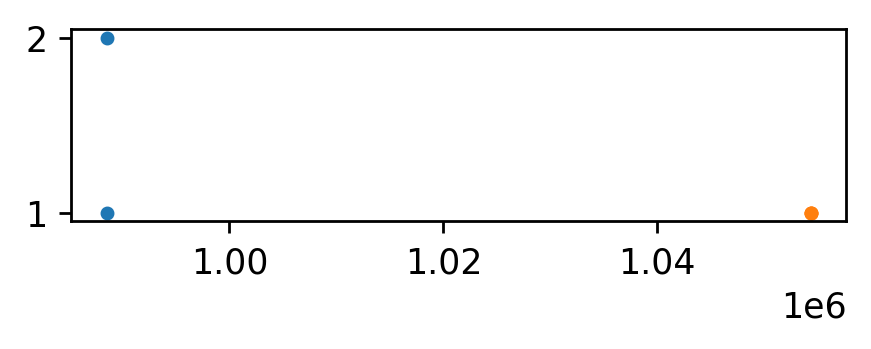

In [210]:
fig, ax = plt.subplots(figsize=(4, 1))
start_xs = RF_start_pos_count_dict.keys()
end_xs = RF_end_pos_count_dict.keys()
start_ys = [RF_start_pos_count_dict[x] for x in start_xs]
end_ys = [RF_end_pos_count_dict[x] for x in end_xs]
ax.plot(start_xs, start_ys, '.')
ax.plot(end_xs, end_ys, '.')